# HealthCare Fraud Detection

## Required packages and settings

In [1]:
# common
import re
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.auto import tqdm
from itertools import combinations
from copy import copy

# mlxtend (apriori)
from mlxtend.frequent_patterns import apriori, association_rules

# main regarding vizualizations
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# imblearn
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids

# catboost
import catboost as ctb

# interactive visualizations
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# tensorflow keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec, Dropout
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import Adam, SGD

# adjust plotting style
rcdict = {
    'grid.linewidth'  : 1,
    'xtick.major.size': 0,
    'ytick.major.size': 0,
    'xtick.minor.size': 0,
    'ytick.minor.size': 0
}

jtplot.style(
    theme='grade3', 
    context='talk',
    fscale=1.4, 
    spines=False, 
    gridlines='--'
)

sns.set_context('talk', rc=rcdict)

## Data observation and preprocessing

In [2]:
# Load Dataset

train = pd.read_csv('healthcare_data/Train-1542865627584.csv')
train_ben = pd.read_csv("healthcare_data/Train_Beneficiarydata-1542865627584.csv")
train_inp = pd.read_csv("healthcare_data/Train_Inpatientdata-1542865627584.csv")
train_outp = pd.read_csv("healthcare_data/Train_Outpatientdata-1542865627584.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


In [4]:
train_ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [5]:
train_inp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [6]:
train_outp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  517737 non-null  object 
 1   ClaimID                 517737 non-null  object 
 2   ClaimStartDt            517737 non-null  object 
 3   ClaimEndDt              517737 non-null  object 
 4   Provider                517737 non-null  object 
 5   InscClaimAmtReimbursed  517737 non-null  int64  
 6   AttendingPhysician      516341 non-null  object 
 7   OperatingPhysician      90617 non-null   object 
 8   OtherPhysician          195046 non-null  object 
 9   ClmDiagnosisCode_1      507284 non-null  object 
 10  ClmDiagnosisCode_2      322357 non-null  object 
 11  ClmDiagnosisCode_3      203257 non-null  object 
 12  ClmDiagnosisCode_4      125596 non-null  object 
 13  ClmDiagnosisCode_5      74344 non-null   object 
 14  ClmDiagnosisCode_6  

In [7]:
# some data preprocessing
train_inp['Inpatient'] = 1
train_outp['Inpatient'] = 0

In [8]:
# merge to complete dataset
train_merged = train_ben.merge(

        pd.concat([train_inp, train_outp]), 
        on='BeneID'

    ).copy()

In [9]:
# check columns
train_merged.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'Cl

Convert date columns to datetime type

In [10]:
to_datetime = ['ClaimStartDt', 'ClaimEndDt', 'DOB', 'DischargeDt', 'AdmissionDt']

for c in to_datetime:
    
    train_merged[c] = pd.to_datetime(train_merged[c])

Convert to bool representation

In [11]:
cond_cols = [x for x in train_merged.columns if re.search('ChronicCond', x)]
train_merged[cond_cols] = train_merged[cond_cols] - 1

## 1. MBA: apriori

Here, we will apply some Market Basket Analysis (MBA). This will include pre-existing chronic conditions, diagnosis codes and procedure codes.

### 1.1. Associative patterns

Firstly, let's consider associative patterns - samples with high supports, confidences and lifts. In this case, the most important ones will be consist of our support and confidence since it characterizes how often this subsequence occurs in the data and how strong it's linked between.

#### 1.1.1 Chronic conditions

Choose required columns. To avoid RAM overfill, convert the whole data to `bool` dtype. In addition, rename condition columns to simplify the implications observation.

In [12]:
# extract columns related to pre-ext conditions
cond_cols = [x for x in train_merged.columns if re.search('ChronicCond', x)]

mba_conds = (train_merged[cond_cols]
             .rename(columns=dict( (i, i.replace('ChronicCond_', '').lower()) for i in cond_cols ))
             .astype(bool)
             .copy()
            )

In [151]:
mba_conds

,alzheimer,heartfailure,kidneydisease,cancer,obstrpulmonary,depression,diabetes,ischemicheart,osteoporasis,rheumatoidarthritis,stroke
0,False,True,False,True,True,False,False,False,True,False,False
1,False,True,False,True,True,False,False,False,True,False,False
2,False,True,False,True,True,False,False,False,True,False,False
3,True,True,True,True,True,True,True,True,True,True,True
4,False,True,True,True,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
558206,False,False,True,True,True,False,False,True,True,False,True
558207,False,False,True,True,True,False,False,True,True,False,True
558208,False,False,True,True,True,False,False,True,True,False,True
558209,False,False,True,True,True,False,False,True,True,False,True


In [152]:
# apply apriori to the data
frq_items = apriori(mba_conds, min_support=0.1, use_colnames=True)

# build association rules based on frequences, threshold and metrics
rules = association_rules(frq_items, metric='confidence', min_threshold=0.5)

# sort obtained rules by important parameters without ascending
# sort firstly by support to avoid low-frequent patterms
# with high cofidence
rules = (rules
         .sort_values(['support', 'confidence'], ascending = [False, False])
         .reset_index(drop=True)
        )

Build an interactive function to look at frequent implications

In [153]:
def mba_interact(rules, data):
    
    @interact
    def f(Condition=list(data.columns), Min_Confidence=(0, 1, 0.05)):
        
        # set used, because in `antecedents` all values are frozensets 
        # (built-in type related to mlxtend package)
        return rules[(rules.antecedents == set([Condition])) & (rules.confidence >= Min_Confidence)].copy()

In [154]:
mba_interact(rules, mba_conds)

interactive(children=(Dropdown(description='Condition', options=('alzheimer', 'heartfailure', 'kidneydisease',…

Reasonable threshold for confidence is about $0.7$, so we can see that some of the pre-existing conditions have bidirectional connections (e.g. `cancer` and `stroke`)

#### 1.1.2 Claim diagnosis codes

Do the same for diagnosis codes, but we also need to convert the data to bool representation

In [155]:
train_merged.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'Cl

In [13]:
# extract columns related to diagnosis codes
diag_cols = [x for x in train_merged.columns if re.search('ClmDiagnosisCode', x)] + ['ClmAdmitDiagnosisCode']

mba_diags = (train_merged[diag_cols]
             .astype(str)
             .copy()
            )

# extract unique values from claim diagnoses columns
unique_diags = mba_diags.to_numpy().flatten()

# build dict from counts and unique values
diags_counts = dict(zip(*map(list, np.unique(unique_diags, return_counts=True))))
diags_counts.pop('nan') # get rid of NaNs

# sort dict to simplify top-N taking
diags_counts = sorted(diags_counts.items(), key=lambda x: x[1], reverse=True)

Consider only top-100 diagnosis codes by frequence

In [157]:
for dcode, _ in tqdm(diags_counts[:100]):
    
    mba_diags[dcode] = (mba_diags == dcode).sum(1).astype(bool)

mba_diags.drop(diag_cols, axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [158]:
mba_diags[mba_diags.max(1)]

,4019,25000,2724,V5869,4011,42731,V5861,2720,2449,4280,...,7140,71945,5854,V5789,7231,4254,3320,V420,7291,V4365
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558203,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
558204,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
558207,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
558208,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [159]:
# apply apriori to the data (filter out full-False rows)
frq_items = apriori(mba_diags[mba_diags.max(1)], min_support=0.008, use_colnames=True)

# build association rules based on frequences, threshold and metrics
rules = association_rules(frq_items, metric='lift', min_threshold=1)

# sort obtained rules by important parameters without ascending
rules = (rules
         .sort_values(['confidence', 'lift'], ascending = [False, False])
         .reset_index(drop=True)
        )

In [160]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(58881),(28521),0.021299,0.029628,0.012592,0.591183,19.953703,0.011961,2.373610
1,(2809),(28521),0.024256,0.029628,0.011102,0.457682,15.447763,0.010383,1.789305
2,(58881),(2809),0.021299,0.024256,0.009221,0.432913,17.847506,0.008704,1.720626
3,(28521),(58881),0.029628,0.021299,0.012592,0.425000,19.953703,0.011961,1.702088
4,(2809),(58881),0.024256,0.021299,0.009221,0.380139,17.847506,0.008704,1.578905
5,(28521),(2809),0.029628,0.024256,0.011102,0.374705,15.447763,0.010383,1.560453
6,(41401),(4019),0.043418,0.228810,0.013636,0.314057,1.372568,0.003701,1.124278
7,(53081),(4019),0.044130,0.228810,0.013749,0.311571,1.361700,0.003652,1.120217
8,(2724),(4019),0.107692,0.228810,0.031926,0.296453,1.295628,0.007285,1.096145
9,(41400),(4019),0.036148,0.228810,0.010507,0.290658,1.270304,0.002236,1.087191


As we can see, there are some examples with very high lift and quite high confidence, but in comparison with pre-existing conditions, it's too little, because we have a lot of different diagnosis codes (about 10k unique ones).

#### 1.1.3. Procedure codes

In [14]:
# extract columns related to procedure codes
proc_cols = [x for x in train_merged.columns if re.search('ClmProcedureCode', x)]

mba_procs = (train_merged[proc_cols]
             .astype(str)
             .copy()
            )

# extract unique values from claim procedure columns
unique_procs = mba_procs.to_numpy().flatten()

# build dict from counts and unique values
procs_counts = dict(zip(*map(list, np.unique(unique_procs, return_counts=True))))
procs_counts.pop('nan') # get rid of filled NaNs

# sort dict to simplify top-N taking
procs_counts = sorted(procs_counts.items(), key=lambda x: x[1], reverse=True)

Again, consider only top-100 items

In [162]:
for pcode, _ in tqdm(procs_counts[:100]):
    
    mba_procs[pcode] = (mba_procs == pcode).sum(1).astype(bool)

mba_procs.drop(proc_cols, axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
# apply apriori to the data (filter out full-False rows)
frq_items = apriori(mba_procs[mba_procs.max(1)], min_support=0.001, use_colnames=True)

# build association rules based on frequences, threshold and metrics
rules = association_rules(frq_items, metric='lift', min_threshold=1)

# sort obtained rules by important parameters without ascending
rules = (rules
         .sort_values(['confidence', 'lift'], ascending = [False, False])
         .reset_index(drop=True)
        )

In [49]:
rules.head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(2724.0, 4139.0)",(66.0),0.002208,0.051013,0.001585,0.717949,14.073707,0.001473,3.364589
1,"(4019.0, 4139.0)",(66.0),0.001529,0.051013,0.001019,0.666667,13.068442,0.000941,2.846960
2,(4139.0),(66.0),0.007304,0.051013,0.004077,0.558140,10.941022,0.003704,2.147706
3,"(4019.0, 2724.0)",(66.0),0.011211,0.051013,0.004926,0.439394,8.613292,0.004354,1.692787
4,"(4139.0, 66.0)",(2724.0),0.004077,0.059676,0.001585,0.388889,6.516656,0.001342,1.538712
5,(66.0),(4019.0),0.051013,0.110916,0.016306,0.319645,2.881862,0.010648,1.306794
6,(66.0),(2724.0),0.051013,0.059676,0.016023,0.314095,5.263334,0.012979,1.370925
7,"(2724.0, 66.0)",(4019.0),0.016023,0.110916,0.004926,0.307420,2.771649,0.003149,1.283728
8,(4139.0),(2724.0),0.007304,0.059676,0.002208,0.302326,5.066105,0.001772,1.347798
9,"(4019.0, 66.0)",(2724.0),0.016306,0.059676,0.004926,0.302083,5.062045,0.003953,1.347330


As for the diagnoses, we can see several high-confidence cases. Low support, as before, is due to the large number of procedures in the data.

### 1.2. Relationships

Consider high-confidence relations between pre-existing conditions and diagnoses/procedures

#### 1.2.1 Chronic conditions and claim diagnosis codes

In [50]:
# build conditions data
mba_conds = (train_merged[cond_cols]
             .rename(columns=dict( (i, i.replace('ChronicCond_', '').lower()) for i in cond_cols ))
             .astype(bool)
             .copy()
            )

# build diagnoses data
mba_diags = (train_merged[diag_cols]
             .astype(str)
             .copy()
            )

# extract unique values from claim diagnoses columns
unique_diags = mba_diags.to_numpy().flatten()

# build dict from counts and unique values
diags_counts = dict(zip(*map(list, np.unique(unique_diags, return_counts=True))))
diags_counts.pop('nan') # get rid of NaNs

# sort dict to simplify top-N taking
diags_counts = sorted(diags_counts.items(), key=lambda x: x[1], reverse=True)

# build concatenated dataset
#

# top-100 diagnoses
for dcode, _ in tqdm(diags_counts[:100]):
    
    mba_diags[dcode] = (mba_diags == dcode).sum(1).astype(bool)

mba_diags = mba_diags[mba_diags.max(1)].copy()

mba_rel_conds_diags = pd.concat([mba_conds.loc[mba_diags.index], mba_diags], axis=1)
mba_rel_conds_diags.drop(diag_cols, axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
# apply apriori to the data (filter out full-False rows)
frq_items = apriori(mba_rel_conds_diags[mba_rel_conds_diags.max(1)], min_support=0.04, use_colnames=True)

# build association rules based on frequences, threshold and metrics
rules = association_rules(frq_items, metric='lift', min_threshold=1)

# sort obtained rules by important parameters without ascending
rules = (rules
         .sort_values(['confidence', 'lift'], ascending = [False, False])
         .reset_index(drop=True)
        )

In [71]:
def mba_interact_relations(rules, data):
    
    global cond_cols
    
    other = list(set(data.columns).difference(set(cond_cols)))
    cond_cols_ = set(map(lambda s: s.replace('ChronicCond_', '').lower(), cond_cols))
    
    @interact
    def f(Condition=cond_cols_, Min_Confidence=(0, 1, 0.05)):
        
        # set used, because in `antecedents` all values are frozensets 
        # (built-in type related to mlxtend package)
        return rules[

                #(rules.antecedents == set([Condition])) & \
                (rules.antecedents.apply(
                    lambda x: x.intersection(set([Condition])) != set())) & \
                (rules.consequents.apply(
                    lambda x: not x.intersection(cond_cols_))) & \
                (rules.confidence >= Min_Confidence)

            ].copy()

In [60]:
mba_interact_relations(rules, mba_rel_conds_diags)

interactive(children=(Dropdown(description='Condition', options=('diabetes', 'rheumatoidarthritis', 'depressio…

#### 1.2.2 Chronic conditions and claim procedure codes

In [66]:
# build conditions data
mba_conds = (train_merged[cond_cols]
             .rename(columns=dict( (i, i.replace('ChronicCond_', '').lower()) for i in cond_cols ))
             .astype(bool)
             .copy()
            )

# build diagnoses data
mba_procs = (train_merged[proc_cols]
             .astype(str)
             .copy()
            )

# extract unique values from claim diagnoses columns
unique_procs = mba_procs.to_numpy().flatten()

# build dict from counts and unique values
procs_counts = dict(zip(*map(list, np.unique(unique_procs, return_counts=True))))
procs_counts.pop('nan') # get rid of NaNs

# sort dict to simplify top-N taking
procs_counts = sorted(procs_counts.items(), key=lambda x: x[1], reverse=True)

# build concatenated dataset
#

# top-100 diagnoses
for pcode, _ in tqdm(procs_counts[:100]):
    
    mba_procs[pcode] = (mba_procs == pcode).sum(1).astype(bool)

mba_procs = mba_procs[mba_procs.max(1)].copy()

mba_rel_conds_procs = pd.concat([mba_conds.loc[mba_procs.index], mba_procs], axis=1)
mba_rel_conds_procs.drop(proc_cols, axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
# apply apriori to the data (filter out full-False rows)
frq_items = apriori(mba_rel_conds_procs[mba_rel_conds_procs.max(1)], min_support=0.04, use_colnames=True)

# build association rules based on frequences, threshold and metrics
rules = association_rules(frq_items, metric='lift', min_threshold=1)

# sort obtained rules by important parameters without ascending
rules = (rules
         .sort_values(['confidence', 'lift'], ascending = [False, False])
         .reset_index(drop=True)
        )

In [72]:
mba_interact_relations(rules, mba_rel_conds_procs)

interactive(children=(Dropdown(description='Condition', options=('diabetes', 'rheumatoidarthritis', 'depressio…

## 2. Unsupervised Learning

### 2.1 Bag-of-Words

Let's apply the BoW approach cocnerning pre-existing conditions, procedure codes and diagnosis codes. Firstly, we must build a function to create the BoW dataset from the mergerd data.

In [15]:
def build_BoW_data(

        doc_col: str = 'Provider', # column for data aggregation (it's not `document` column, just designation)
        term_cols: list = None, # term columns
        data: object = None, # data for aggregation
        unique_provider: bool = False, # specific flag to deal with pre-ext conditions separately
        items: list = None # unique items (top-N codes, relevant for procedures and diagnoses)

    ) -> object:
    
    """Build BoW dataset
    """
    
    # avoid changing original data
    df = data.copy()
    
    # consider only unique visits patients to the same provider
    # if we build BoW for pre-ext conds
    if unique_provider:
        
        df = df.drop_duplicates(['BeneID', doc_col])
    
    # filter out columns
    df = df[[doc_col] + term_cols].copy()
    
    # dealing with NaNs depenging on is it pre-ext conds
    # or not
    if unique_provider:
        
        df.fillna(0., inplace=True)
    
    else:
        
        df = df.astype(str)
    
    # only for procedures and diagnoses to extract values column-wise
    if items:
        
        for item in tqdm(items):
            
            df[f'bow_{item}'] = (df[term_cols] == item).sum(axis=1)
        
        df.drop(term_cols, axis=1, inplace=True)
    
    # aggregate and get rid of full-zero cols
    df = df.groupby(doc_col).sum()
    df = df[df.max(axis=1) > 0].copy()
    
    
    return df

Next, we build datasets for all our cases (procedures, diagnoses, pre-existing conditions)

In [16]:
procedures_bow = build_BoW_data(
    term_cols=proc_cols, # procedure related columns
    data=train_merged, # pass merged data
    items=list( dict(procs_counts[:50]).keys() ) # extract top-50 procedures
)

diags_bow = build_BoW_data(
    term_cols=diag_cols, # diagnosis related columns
    data=train_merged, # pass merged data
    items=list( dict(diags_counts[:50]).keys() ) # extract top-50 diagnoses
)

precond_bow = build_BoW_data(
    term_cols=cond_cols, # conditions related columns
    data=train_merged, # pass merged data 
    unique_provider=True # mark specifig flag as True
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Also we need to write function for initial clustering. We will use it to estimate optimal number of clusters for further deep clustering. For estimation we use two scores:  silhouette score (https://en.wikipedia.org/wiki/Silhouette_(clustering)) and Davies-Bouldin score (https://en.wikipedia.org/wiki/Davies–Bouldin_index) - considering extremums of both scores.

In [17]:
def clustering(

        estimator: object, # kmeans or aggclust
        params: dict, # parameters related to the estimator
        data: object, # data for the clustering
        n_clusts: list = range(3, 20), # range n_clusters for estimation
        scale: bool = True # scale features or not (normalization)

    ) -> dict:
    
    """Apply clustering with custom estimator
    """
    
    dt = data.copy() # avoid inpalce changes
    
    # scale if pased and store scaler
    if scale:
        
        scaler = StandardScaler().fit(dt)
        dt = scaler.transform(dt)
    
    else:
        
        scaler = None
    
    # store all trained models with scores
    models = {}
    
    for n in tqdm(n_clusts):
        
        model = estimator(n_clusters=n, **params).fit(dt)
        
        try:
            # works for kmeans
            labels = model.predict(dt)
        
        except:
            # works for aggclustering
            labels = model.labels_
        
        # calculate scores
        silhouette = silhouette_score(dt, labels) 
        dav_boul = davies_bouldin_score(dt, labels)
        
        models[n] = {'model' : model, 'silhouette' : silhouette, 'dav_boul' : dav_boul}
    
    
    return {'scaler' : scaler, 'models' : models}

And one more function to simplify visualizations

In [18]:
def plot_clustering_stats(

        data: object, # original data
        clust_dict: dict # output from clustering

    ):
    
    dt = data.copy()
    scaler = clust_dict.get('scaler')
    models = clust_dict.get('models')
    
    if scaler:
        
        dt = scaler.transform(dt)
    
    # visualize
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(x=list(models.keys()), y=[models[w]['silhouette'] for w in models.keys()], ax=ax[0])
    sns.lineplot(x=list(models.keys()), y=[models[w]['dav_boul'] for w in models.keys()], ax=ax[1])

    ax[0].set_xlabel('n_clusters', labelpad=15, fontsize=12)
    ax[0].set_ylabel('silhouette', labelpad=15, fontsize=12)
    ax[1].set_xlabel('n_clusters', labelpad=15, fontsize=12)
    ax[1].set_ylabel('davies_bouldin', labelpad=15, fontsize=12)
    
    return fig, ax

Creating a keras-based deepclustering model. It uses clustering-layer used with t-student distribution for optimizing Kullback–Leibler divergence (relative entropy, https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) and creates clusters. In addition, Autoencoder is used here.

In [19]:
class ClusteringLayer(Layer):

    """Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

        Parameters
        ------------
        n_clusters
            Number of clusters.

        weights
            List of Numpy array with shape `(n_clusters, n_features)`which 
            represents the initial cluster centers.

        alpha: optional
            Degrees of freedom parameter in Student's t-distribution. 
            Default to 1.0.

        Input shape
        ------------
            2D tensor with shape: `(n_samples, n_features).

        Output shape
        ------------
            2D tensor with shape: `(n_samples, n_clusters).

    """

    def __init__(

            self, 
            n_clusters, 
            weights=None, 
            alpha=1.0, 
            **kwargs

        ):

        """
        """

        if 'input_shape' not in kwargs and 'input_dim' in kwargs:

            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super().__init__(**kwargs)

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    # ------------------------- #

    def build(self, input_shape):

        assert len(input_shape) == 2
        input_dim = input_shape[1]

        self.input_spec = InputSpec(

                dtype=K.floatx(), 
                shape=(None, input_dim)

            )

        self.clusters = self.add_weight(

                shape=(self.n_clusters, input_dim), 
                initializer='glorot_uniform', 
                name='clusters'

            )


        if self.initial_weights:

            self.set_weights(self.initial_weights)
            del self.initial_weights


        self.built = True

    # ------------------------- #

    def call(self, inputs, **kwargs):

        """Student t-distribution, as same as used in t-SNE algorithm.

            Measure the similarity between embedded point z_i and centroid µ_j.
            q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
            q_ij can be interpreted as the probability of assigning sample i to cluster j.
            (i.e., a soft assignment)

            Parameters
            ----------
            inputs
                The variable containing data, shape is (n_samples, n_features).
            
            Returns
            ----------
            q
                Student's t-distribution, or soft labels for each sample. 
                Shape is (n_samples, n_clusters).

        """

        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.


        return q

    # ------------------------- #

    def compute_output_shape(self, input_shape):

        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    # ------------------------- #

    def get_config(self):

        config = {'n_clusters': self.n_clusters}
        base_config = super().get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [20]:
class AutoEncoder(Model):

    """Autoencoder model
    """

    def __init__(

            self,
            data_shape: tuple,
            latent_space_size: int = 20,
            ae_layers_half: tuple = (100, 80, 50),
            enc_activation: str = 'relu',
            dec_activation: str = 'relu',
            last_activation: str = 'selu',
            **kwargs

        ):

        """
        """

        super().__init__(**kwargs)

        self.latent_space_size = latent_space_size
        
        # initi with var_scal weights (not necessary)
        init = VarianceScaling(

            scale=1. / 3., 
            mode='fan_in', 
            distribution='uniform'

        )
        
        # build dense layers mapping from the input config
        ae_layers_half = (data_shape[1],) + ae_layers_half + (latent_space_size,)

        # encoder
    
        nst = len(ae_layers_half) - 1

        self.ae_encoder_layers = []

        for i in range(nst - 1):

            x = Dense(

                    ae_layers_half[i + 1], 
                    activation=enc_activation, 
                    kernel_initializer=init, 
                    name=f'encoder_{i}'

                )

            self.ae_encoder_layers.append(x)

        # latent space
        
        self.ae_latent = Dense(

                ae_layers_half[-1],
                activation=enc_activation, 
                kernel_initializer=init, 
                name=f'encoder_{nst - 1}'

            )

        # decoder

        self.ae_decoder_layers = []

        for i in range(nst - 1, 0, -1):

            x = Dense(

                    ae_layers_half[i], 
                    activation=dec_activation, 
                    kernel_initializer=init, 
                    name=f'decoder_{i}'

                )

            self.ae_decoder_layers.append(x)

        # output
        
        self.ae_output_layer = Dense(

                ae_layers_half[0],
                activation=last_activation,
                kernel_initializer=init,
                name='decoded'

            )

    # ------------------------- #

    def call(self, inputs, **kwargs):

        x = inputs

        for layer in self.ae_encoder_layers:
            x = layer(x)

        x = self.ae_latent(x)

        for layer in self.ae_decoder_layers:
            x = layer(x)

        y = self.ae_output_layer(x)

        return y

    # ------------------------- #

    def slice_encoder(self):

        enc = Sequential()

        for layer in self.ae_encoder_layers:
            enc.add(layer)

        enc.add(self.ae_latent)


        return enc

# ------------------------- #

In [21]:
class DeepClustering(Model):
    
    # default autoencoder configuration
    AE_DEFAULT_CONFIG = {

        'ae_layers_half'  : (100, 80, 50), # (inp_shape, 100, 80, 50, n_clusters, 50, 80, 100, inp_shape)
        'enc_activation'  : 'relu', # encoder activation
        'dec_activation'  : 'relu', # decoder activation
        'last_activation' : 'selu', # output activation (adjustable)
        'learning_rate'   : 1e-5, # learning rate
        'loss'            : 'mse' # optimized loss

    }

    # ------------------------- #

    def __init__(

            self,
            data_shape: tuple,
            n_clusters: int = 20,
            ae_config: dict = dict(),
            **kwargs

        ):

        """
        """

        super().__init__(**kwargs)

        ae_config = dict({**self.AE_DEFAULT_CONFIG, **ae_config})
        ae_config.update({

            'data_shape' : data_shape,
            'latent_space_size' : n_clusters

        })

        ae_lr = ae_config.pop('learning_rate')
        ae_loss = ae_config.pop('loss')

        self.n_clusters = n_clusters
        
        # initialize and compile autoencoder
        self.autoencoder = AutoEncoder(**ae_config)
        self.autoencoder.compile(

            optimizer=Adam(ae_lr),
            loss=ae_loss

        )
        
        # initialize and build clustering layer
        self.cllayer = ClusteringLayer(

                n_clusters=n_clusters,
                name='clustering'

            )

        self.cllayer.build(input_shape=(None, n_clusters))

    # ------------------------- #

    def call(self, inputs, **kwargs):

        x = inputs

        for layer in self.autoencoder.ae_encoder_layers:
            x = layer(x)

        x = self.autoencoder.ae_latent(x)
        y = self.cllayer(x)


        return y

    # ------------------------- #

    def fit(

            self,
            data,
            iter: int = 15000,
            update_interval: int = 100,
            ae_epochs: int = 300,
            ae_batch_size: int = 64,
            batch_size: int = 32,
            tolerance: float = 1e-3,
            **kwargs

        ):

        """
        """

        # firstly fit the autoencoder
        self.autoencoder.fit(

            data, data,
            epochs=ae_epochs,
            batch_size=ae_batch_size,

        )

        # next fit deepclustering layer

        index = 0
        loss = 0

        try:
            
            data = data.to_numpy()

        except:

            pass

        # starts with kmeans initialization and go deeper

        kmeans_init = KMeans(

                n_clusters=self.n_clusters, 
                n_init=20, 
                verbose=1

            )
        
        encoder = self.autoencoder.slice_encoder()
        y_pred = kmeans_init.fit_predict(encoder.predict(data))
        y_pred_last = np.copy(y_pred)

        (self

            .get_layer(name='clustering')
            .set_weights([kmeans_init.cluster_centers_])

        )

        index_array = np.arange(data.shape[0])

        # deep training process

        for ite in tqdm(range(iter)):

            if ite % update_interval == 0:

                q = self.predict(data, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                
                # check stop criterion - model convergence
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                

                if ite > 0 and delta_label < tolerance:

                    print('delta_label ', delta_label, '< tolerance ', tolerance)
                    print('Reached tolerance threshold. Stopping training.')

                    break
                    

            idx = index_array[index * batch_size: min((index+1) * batch_size, data.shape[0])]
            loss = self.train_on_batch(x=data[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= data.shape[0] else 0

    # ------------------------- #

    @staticmethod
    def target_distribution(x):

        weight = x ** 2 / x.sum(0)

        return (weight.T / weight.sum(1)).T

#### 2.1.1 Pre-existing conditions

  0%|          | 0/27 [00:00<?, ?it/s]

(<Figure size 1080x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='n_clusters', ylabel='silhouette'>,
        <AxesSubplot:xlabel='n_clusters', ylabel='davies_bouldin'>],
       dtype=object))

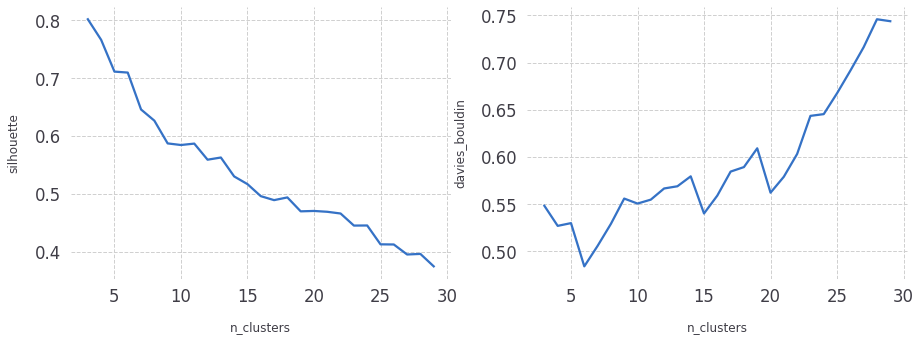

In [213]:
data0 = precond_bow.copy()

kmeans0 = clustering(
    
    estimator=KMeans, 
    params=dict(max_iter=10000, n_init=10), 
    data=data0,
    n_clusts=range(3, 30)
    
)

plot_clustering_stats(data0, kmeans0)

  0%|          | 0/27 [00:00<?, ?it/s]

(<Figure size 1080x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='n_clusters', ylabel='silhouette'>,
        <AxesSubplot:xlabel='n_clusters', ylabel='davies_bouldin'>],
       dtype=object))

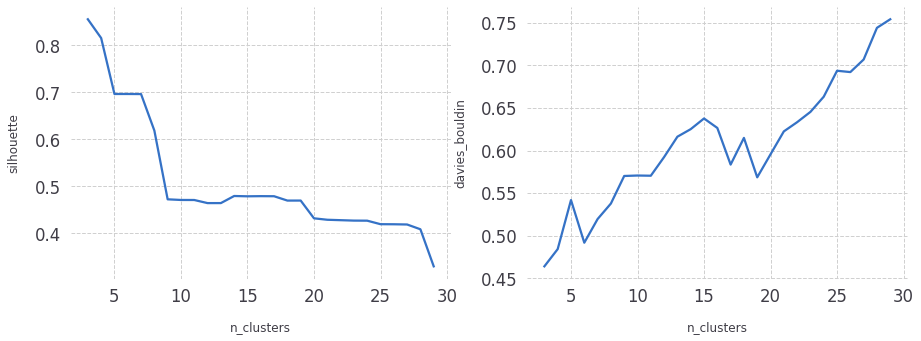

In [214]:
aggclust0 = clustering(
    
    estimator=AgglomerativeClustering, 
    params=dict(), 
    data=data0,
    n_clusts=range(3, 30)
    
)

plot_clustering_stats(data0, aggclust0)

We can see that 7 clusters is a good choice comparing two graphs. Let's use it in further deepclustering.

In [215]:
deepclust0 = DeepClustering(data_shape=data0.shape, n_clusters=7)
scaler0 = StandardScaler().fit(data0)
data0_sc = scaler0.transform(data0)

Compile and fit deepclustering model

In [216]:
deepclust0.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='kld' # kullback-leibler divergence (relative entropy)
)

deepclust0.fit(data0_sc)

Epoch 1/300
85/85 [==============================] - 1s 2ms/step - loss: 1.0022
Epoch 2/300
85/85 [==============================] - 0s 2ms/step - loss: 1.0002
Epoch 3/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9986
Epoch 4/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9970
Epoch 5/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9947
Epoch 6/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9915
Epoch 7/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9865
Epoch 8/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9794
Epoch 9/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9690
Epoch 10/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9545
Epoch 11/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9357
Epoch 12/300
85/85 [==============================] - 0s 2ms/step - loss: 0.9114
Epoch 13/300
85/85 [=================

85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 203/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 204/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 205/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 206/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 207/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 208/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 209/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 210/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 211/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 212/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 213/300
85/85 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 214/300
85/85 [=========

Initialization complete
Iteration 0, inertia 4066.955810546875
Iteration 1, inertia 2963.6552734375
Iteration 2, inertia 2946.25390625
Iteration 3, inertia 2943.4052734375
Iteration 4, inertia 2941.681396484375
Iteration 5, inertia 2940.83447265625
Iteration 6, inertia 2940.54638671875
Converged at iteration 6: center shift 1.9691959096235223e-05 within tolerance 0.00017551296949386598.
Initialization complete
Iteration 0, inertia 4247.1826171875
Iteration 1, inertia 3705.16845703125
Iteration 2, inertia 3595.962158203125
Iteration 3, inertia 3520.9111328125
Iteration 4, inertia 3404.9453125
Iteration 5, inertia 3330.511962890625
Iteration 6, inertia 3273.68017578125
Iteration 7, inertia 3229.25732421875
Iteration 8, inertia 3196.835205078125
Iteration 9, inertia 3168.229736328125
Iteration 10, inertia 3132.1318359375
Iteration 11, inertia 3104.62744140625
Iteration 12, inertia 3091.8330078125
Iteration 13, inertia 3088.909423828125
Iteration 14, inertia 3086.78125
Iteration 15, inerti

  0%|          | 0/15000 [00:00<?, ?it/s]

Predict clusters

In [217]:
clusters = deepclust0.predict(data0_sc).argmax(1)

precond_clust_dict = zip(data0.index, clusters) # store for further purposes

Specific function for PCA (principal component analysis) clusters visualization

In [218]:
def pca_plot(data, clusters, ylim=None, xlim=None):
    
    df = data.copy()

    pca = PCA(2) # two-dimensional plot
    new_X = pca.fit_transform(df)
    
    # build new df for visualization
    new_df = pd.DataFrame(data={'x' : new_X[:, 0],
                                'y' : new_X[:, 1],
                                'cluster' : clusters})

    fig, ax = plt.subplots(figsize=(14, 10))
    sns.scatterplot(data=new_df, x='x', y='y', hue='cluster', ax=ax, s=60, palette='deep')
    
    # specify axs limits if passed
    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

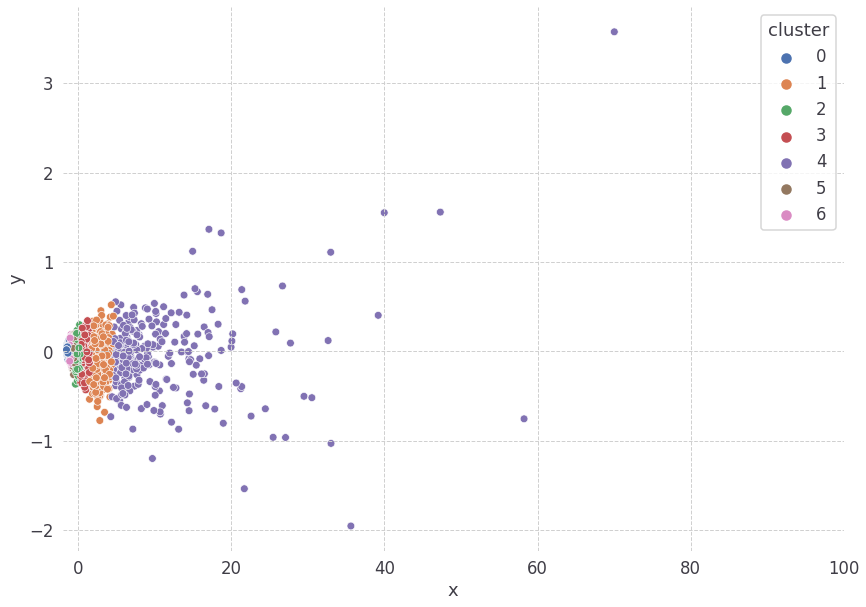

In [219]:
pca_plot(data0_sc, clusters, xlim=(-2, 100))

We can see very strong outliers in two-dimensional space related to the 4th cluster. These ones are likeley very large providers and also providers serving patients with all possible pre-existing conditions, so it might be not too representative, but we can trace each particular provider's specific direction in terms of these conditions.

#### 2.1.2 Diagnosis codes

  0%|          | 0/17 [00:00<?, ?it/s]

(<Figure size 1080x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='n_clusters', ylabel='silhouette'>,
        <AxesSubplot:xlabel='n_clusters', ylabel='davies_bouldin'>],
       dtype=object))

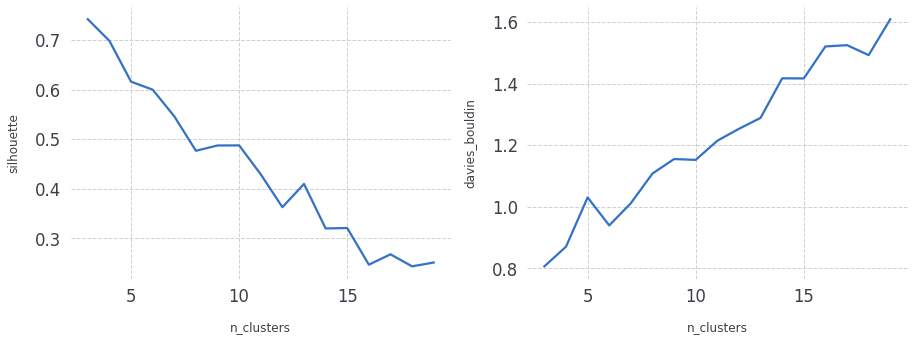

In [222]:
data = diags_bow.copy()

kmeans = clustering(
    
    estimator=KMeans, 
    params=dict(max_iter=10000, n_init=10), 
    data=data
    
)

plot_clustering_stats(data, kmeans)

  0%|          | 0/17 [00:00<?, ?it/s]

(<Figure size 1080x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='n_clusters', ylabel='silhouette'>,
        <AxesSubplot:xlabel='n_clusters', ylabel='davies_bouldin'>],
       dtype=object))

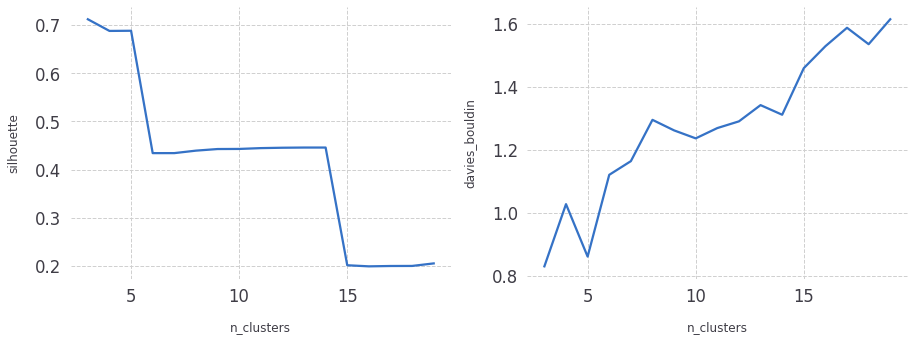

In [223]:
aggclust = clustering(
    
    estimator=AgglomerativeClustering, 
    params=dict(), 
    data=data
    
)

plot_clustering_stats(data, aggclust)

Again, 7 is most suitable variant comparing both graphs. We know that potentially fraud providers might be not too far from non-fraud ones, so silhouette might be not too large, but stable.

In [227]:
deepclust = DeepClustering(data_shape=data.shape, n_clusters=7)
scaler = StandardScaler().fit(data)
data_sc = scaler.transform(data)

deepclust.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='kld' # kullback-leibler divergence (relative entropy)
)

deepclust.fit(data_sc)

Epoch 1/300
83/83 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 2/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9998
Epoch 3/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9994
Epoch 4/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9988
Epoch 5/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9976
Epoch 6/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9954
Epoch 7/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9918
Epoch 8/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9860
Epoch 9/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9769
Epoch 10/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9638
Epoch 11/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9456
Epoch 12/300
83/83 [==============================] - 0s 2ms/step - loss: 0.9220
Epoch 13/300
83/83 [=================

83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 203/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 204/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 205/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 206/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 207/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 208/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 209/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 210/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 211/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 212/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 213/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 214/300
83/83 [=========

Iteration 8, inertia 27034.564453125
Iteration 9, inertia 27024.0625
Iteration 10, inertia 27020.0703125
Iteration 11, inertia 27019.845703125
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 37066.01171875
Iteration 1, inertia 28198.81640625
Iteration 2, inertia 27767.439453125
Iteration 3, inertia 27657.96484375
Iteration 4, inertia 27621.900390625
Iteration 5, inertia 27595.232421875
Iteration 6, inertia 27575.732421875
Iteration 7, inertia 27564.48828125
Iteration 8, inertia 27563.318359375
Iteration 9, inertia 27560.658203125
Iteration 10, inertia 27559.302734375
Converged at iteration 10: center shift 0.000271491298917681 within tolerance 0.0006732354640960694.
Initialization complete
Iteration 0, inertia 32621.927734375
Iteration 1, inertia 27632.673828125
Iteration 2, inertia 27466.91796875
Iteration 3, inertia 27454.4765625
Iteration 4, inertia 27450.44921875
Iteration 5, inertia 27448.154296875
Iteration 6, inertia 27443.740234375
It

Initialization complete
Iteration 0, inertia 39867.29296875
Iteration 1, inertia 29127.88671875
Iteration 2, inertia 27966.9140625
Iteration 3, inertia 27526.345703125
Iteration 4, inertia 27425.916015625
Iteration 5, inertia 27235.791015625
Iteration 6, inertia 26898.0
Iteration 7, inertia 26705.869140625
Iteration 8, inertia 26554.44921875
Iteration 9, inertia 26495.41796875
Iteration 10, inertia 26442.15234375
Iteration 11, inertia 26400.001953125
Iteration 12, inertia 26395.79296875
Iteration 13, inertia 26394.66015625
Iteration 14, inertia 26394.24609375
Converged at iteration 14: center shift 0.00015181525668594986 within tolerance 0.0006732354640960694.


  0%|          | 0/15000 [00:00<?, ?it/s]

In [228]:
clusters = deepclust.predict(data_sc).argmax(1)

diag_clust_dict = zip(data.index, clusters) # store for further purposes

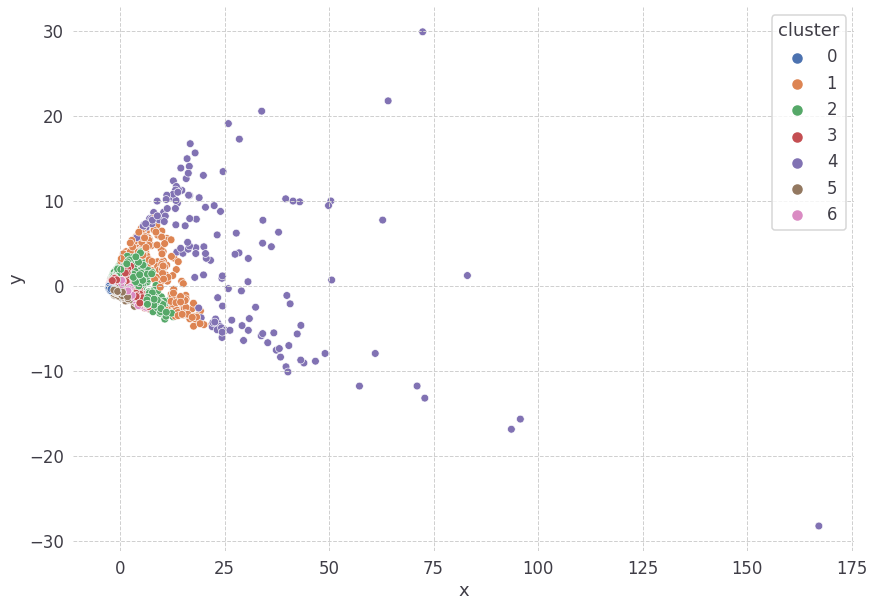

In [229]:
pca_plot(data_sc, clusters)

Here, we can see strong outliers for 4th cluster again, but it's pure outlier class, so it'll be very helpful in further classification purposes

#### 2.1.3 Procedure codes

  0%|          | 0/17 [00:00<?, ?it/s]

(<Figure size 1080x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='n_clusters', ylabel='silhouette'>,
        <AxesSubplot:xlabel='n_clusters', ylabel='davies_bouldin'>],
       dtype=object))

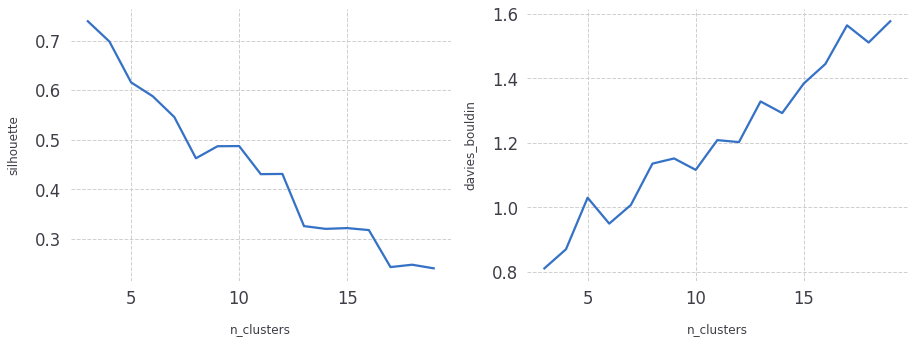

In [30]:
data2 = procedures_bow.copy()

kmeans2 = clustering(
    
    estimator=KMeans, 
    params=dict(max_iter=10000, n_init=10), 
    data=data,
    scale=True
    
)

plot_clustering_stats(data2, kmeans2)

  0%|          | 0/17 [00:00<?, ?it/s]

(<Figure size 1080x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='n_clusters', ylabel='silhouette'>,
        <AxesSubplot:xlabel='n_clusters', ylabel='davies_bouldin'>],
       dtype=object))

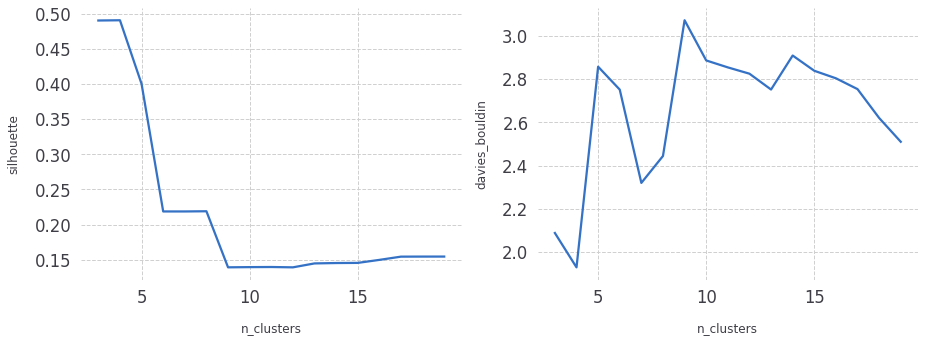

In [166]:
aggclust2 = clustering(
    
    estimator=AgglomerativeClustering, 
    params=dict(), 
    data=data2,
    scale=True
    
)

plot_clustering_stats(data2, aggclust2)

bla bla 5 clusters

In [31]:
deepclust2 = DeepClustering(data_shape=data2.shape, n_clusters=6)
scaler2 = StandardScaler().fit(data2)
data2_sc = scaler2.transform(data2)

deepclust2.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='kld' # kullback-leibler divergence (relative entropy)
)

deepclust2.fit(data2_sc)

Epoch 1/300
29/29 [==============================] - 1s 2ms/step - loss: 1.0002
Epoch 2/300
29/29 [==============================] - 0s 2ms/step - loss: 1.0001
Epoch 3/300
29/29 [==============================] - 0s 2ms/step - loss: 1.0001
Epoch 4/300
29/29 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 5/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9999
Epoch 6/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9999
Epoch 7/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9998
Epoch 8/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9997
Epoch 9/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9996
Epoch 10/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9995
Epoch 11/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9994
Epoch 12/300
29/29 [==============================] - 0s 2ms/step - loss: 0.9993
Epoch 13/300
29/29 [=================

29/29 [==============================] - 0s 2ms/step - loss: 0.6930
Epoch 203/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6929
Epoch 204/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6929
Epoch 205/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6928
Epoch 206/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6928
Epoch 207/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6927
Epoch 208/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6927
Epoch 209/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6926
Epoch 210/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6926
Epoch 211/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6925
Epoch 212/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6925
Epoch 213/300
29/29 [==============================] - 0s 2ms/step - loss: 0.6924
Epoch 214/300
29/29 [=========

Initialization complete
Iteration 0, inertia 2493.43212890625
Iteration 1, inertia 1670.112548828125
Iteration 2, inertia 1650.5653076171875
Iteration 3, inertia 1639.033447265625
Iteration 4, inertia 1637.04296875
Iteration 5, inertia 1636.55517578125
Iteration 6, inertia 1636.3233642578125
Iteration 7, inertia 1636.2720947265625
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 2449.022216796875
Iteration 1, inertia 1680.3245849609375
Iteration 2, inertia 1661.921875
Iteration 3, inertia 1654.093505859375
Iteration 4, inertia 1650.1456298828125
Iteration 5, inertia 1648.724853515625
Iteration 6, inertia 1645.7490234375
Iteration 7, inertia 1636.1929931640625
Iteration 8, inertia 1630.2232666015625
Iteration 9, inertia 1628.5789794921875
Iteration 10, inertia 1628.23046875
Iteration 11, inertia 1627.6878662109375
Iteration 12, inertia 1626.3121337890625
Iteration 13, inertia 1625.7677001953125
Iteration 14, inertia 1625.6104736328125
Converged 

Iteration 9, inertia 1653.7623291015625
Iteration 10, inertia 1640.50732421875
Iteration 11, inertia 1637.528076171875
Iteration 12, inertia 1636.7095947265625
Iteration 13, inertia 1636.4627685546875
Iteration 14, inertia 1636.2906494140625
Converged at iteration 14: center shift 0.00010507780825719237 within tolerance 0.0001586714744567871.
Initialization complete
Iteration 0, inertia 2434.35888671875
Iteration 1, inertia 1748.186279296875
Iteration 2, inertia 1730.4425048828125
Iteration 3, inertia 1727.982421875
Iteration 4, inertia 1726.1236572265625
Iteration 5, inertia 1724.6717529296875
Iteration 6, inertia 1723.28369140625
Converged at iteration 6: center shift 0.00013790468801744282 within tolerance 0.0001586714744567871.
Initialization complete
Iteration 0, inertia 2444.680419921875
Iteration 1, inertia 1664.7021484375
Iteration 2, inertia 1633.843994140625
Iteration 3, inertia 1630.2603759765625
Iteration 4, inertia 1629.5531005859375
Iteration 5, inertia 1628.966552734375


  0%|          | 0/15000 [00:00<?, ?it/s]

delta_label  0.0005443658138268917 < tolerance  0.001
Reached tolerance threshold. Stopping training.


In [32]:
clusters = deepclust2.predict(data2_sc).argmax(1)

proc_clust_dict = zip(data2.index, clusters) # store for further purposes

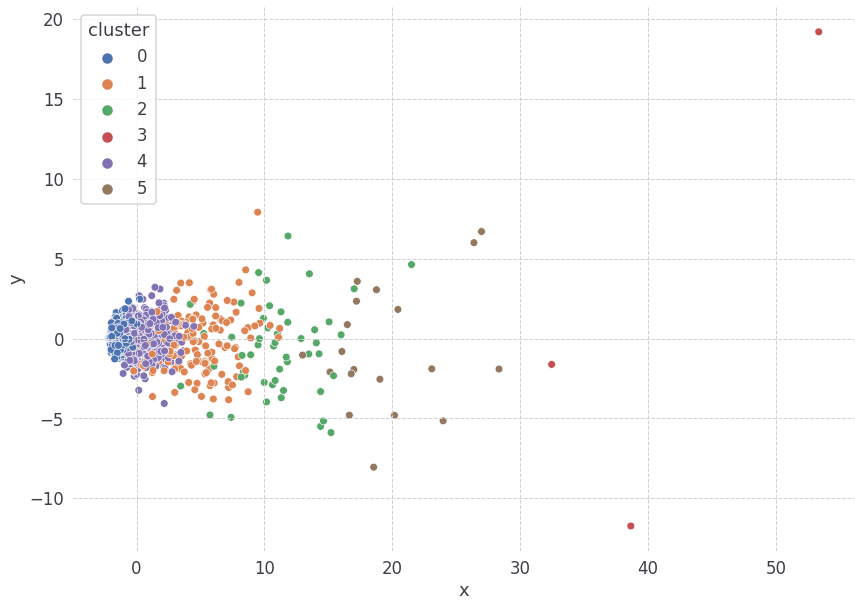

In [176]:
pca_plot(data2_sc, clusters)

For several clusters such as the 2nd, 3rd and 5th, we see large outliers - they definitely will be important later

### 2.2 Unsupervised Clinic Network Analysis

In [95]:
import networkx as nx

graph = nx.Graph()

provider_patients = train_merged.groupby('Provider')['BeneID'].count().to_dict()
couples = train_merged.groupby('BeneID')['Provider'].apply(lambda x: list(x)).to_dict()

In [96]:
edge_dict = dict()

for val in tqdm(couples.values()):
    for pair in list(combinations(val, r=2)):
        
        p1, p2 = pair
        
        if p1 < p2:
            edge_dict[pair] = edge_dict.get(pair, 0) + 1

for k, v in edge_dict.items():
    if v > 5:
        graph.add_edge(*k, weight=v)

  0%|          | 0/138556 [00:00<?, ?it/s]

In [97]:
provider_neighbours = dict()

for k in edge_dict.keys():
    p1, p2 = k
    provider_neighbours[p1] =  provider_neighbours.get(p1, 0) + 1
    provider_neighbours[p2] =  provider_neighbours.get(p2, 0) + 1

for k in provider_patients.keys():
    provider_neighbours[k] = provider_neighbours.get(k, 0)

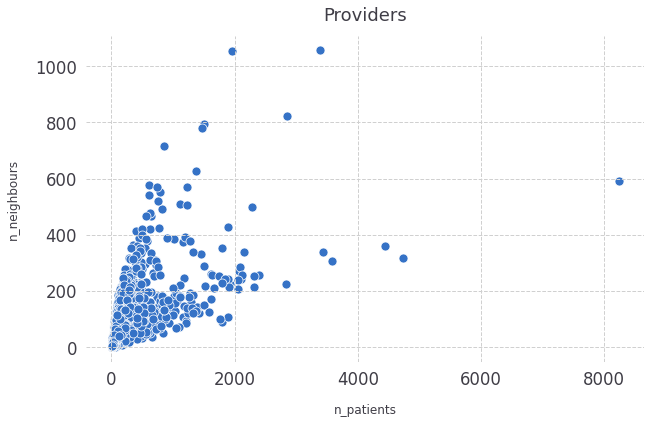

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Providers', pad=15)
ax.set_xlabel('n_patients', labelpad=15, fontsize=12)
ax.set_ylabel('n_neighbours', labelpad=15, fontsize=12)

_ = sns.scatterplot(x=provider_patients.values(), y=[provider_neighbours[p] for p in provider_patients.keys()], ax=ax)

We can see for most of providers with number of patients $\leq 1000$ there is a dense cloud, but for others we can see quite a wide cone spreading, so it mights mean large providers or providers with many neighbours most likely to be potentially fraud.

## 3. Supervised Learning

### 3.1. Regression

In [230]:
train_supl = train_merged.copy()

train_supl['death'] = train_supl.DOD.apply(lambda x: str(x) != 'nan')
train_supl['Age'] = (train_supl.ClaimStartDt - train_supl.DOB).apply(lambda x: x.days // 365)
train_supl['ClaimDuration'] = (train_supl.ClaimEndDt - train_supl.ClaimStartDt).apply(lambda x: x.days)

# add providers embedding to help obtain better results

for dcode, _ in tqdm(diags_counts[:100]):
    train_supl[f'diag_{dcode}'] = (train_supl[diag_cols] == dcode).sum(1).astype(bool)

for pcode, _ in tqdm(procs_counts[:100]):
    train_supl[f'proc_{pcode}'] = (train_supl[proc_cols] == pcode).sum(1).astype(bool)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Drop unnecessary columns

In [231]:
to_drop_cols = [
    
    'AttendingPhysician', 
    'OperatingPhysician', 
    'OtherPhysician', 
    'DischargeDt', 
    'AdmissionDt', 
    'Provider',
    'DiagnosisGroupCode',
    'ClaimStartDt',
    'ClaimEndDt',
    'BeneID',
    'DOB',
    'DOD',
    'ClaimID'
    
] + diag_cols + proc_cols

train_supl.drop(to_drop_cols, axis=1, inplace=True)

preprocess RenalDiseaseIndicator

In [232]:
train_supl.RenalDiseaseIndicator = train_supl.RenalDiseaseIndicator.apply(lambda x: x == 'Y')

In [233]:
target1 = 'DeductibleAmtPaid'
target2 = 'InscClaimAmtReimbursed'
reg_data = train_supl.drop([target1, target2], axis=1).drop_duplicates().copy()

inp_index = reg_data.query('Inpatient == True').index
outp_index = reg_data.query('Inpatient == False').index

labels1 = train_supl[target1].loc[reg_data.index].copy().fillna(0.)
labels2 = train_supl[target2].loc[reg_data.index].copy().fillna(0.)

In [234]:
reg_inp, lab2_inp = reg_data.loc[inp_index], labels2.loc[inp_index]
reg_outp, lab2_outp, lab1_outp = reg_data.loc[outp_index], labels2.loc[outp_index], labels1.loc[outp_index]

#### 3.1.1 InscClaimAmtReimbursed for inpatient

In [235]:
cat_features = [x for i, x in enumerate(reg_data) if i not in [5, 6, 18, 19, 20, 21, 25, 24]]

X_train, X_test, y_train, y_test = train_test_split(reg_inp, lab2_inp, test_size=0.1)

X_train[cat_features] = X_train[cat_features].astype(int).copy()
X_test[cat_features] = X_test[cat_features].astype(int).copy()

/home/misery7100/Programs/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [236]:
train_pool = ctb.Pool(X_train, y_train, cat_features=cat_features)
test_pool = ctb.Pool(X_test, y_test, cat_features=cat_features)

model = ctb.CatBoostRegressor(

        iterations=2000,
        learning_rate=0.05,
        depth=7,
        loss_function='RMSE'

    )

model.fit(train_pool)
preds = model.predict(test_pool)

0:	learn: 9983.0222954	total: 33.7ms	remaining: 1m 7s
1:	learn: 9693.6374566	total: 69.5ms	remaining: 1m 9s
2:	learn: 9411.0243377	total: 96.7ms	remaining: 1m 4s
3:	learn: 9155.6482366	total: 122ms	remaining: 1m 1s
4:	learn: 8909.3814484	total: 148ms	remaining: 59.2s
5:	learn: 8698.4448140	total: 171ms	remaining: 56.8s
6:	learn: 8486.0033408	total: 199ms	remaining: 56.7s
7:	learn: 8288.7343735	total: 226ms	remaining: 56.2s
8:	learn: 8100.1465295	total: 256ms	remaining: 56.7s
9:	learn: 7930.9614517	total: 285ms	remaining: 56.7s
10:	learn: 7771.4304334	total: 323ms	remaining: 58.4s
11:	learn: 7616.3949579	total: 349ms	remaining: 57.8s
12:	learn: 7479.2585165	total: 374ms	remaining: 57.1s
13:	learn: 7342.8696143	total: 397ms	remaining: 56.3s
14:	learn: 7222.2891160	total: 420ms	remaining: 55.5s
15:	learn: 7106.1827646	total: 443ms	remaining: 55s
16:	learn: 6999.3545037	total: 467ms	remaining: 54.5s
17:	learn: 6900.6901502	total: 492ms	remaining: 54.2s
18:	learn: 6805.2716291	total: 515ms	

154:	learn: 5153.7914143	total: 3.68s	remaining: 43.8s
155:	learn: 5151.6287265	total: 3.7s	remaining: 43.7s
156:	learn: 5148.9765587	total: 3.72s	remaining: 43.7s
157:	learn: 5147.6514774	total: 3.75s	remaining: 43.7s
158:	learn: 5142.4892243	total: 3.77s	remaining: 43.6s
159:	learn: 5139.5920484	total: 3.79s	remaining: 43.6s
160:	learn: 5137.3692443	total: 3.81s	remaining: 43.5s
161:	learn: 5134.2609223	total: 3.83s	remaining: 43.5s
162:	learn: 5131.7642400	total: 3.85s	remaining: 43.4s
163:	learn: 5129.1377029	total: 3.87s	remaining: 43.4s
164:	learn: 5125.0513730	total: 3.9s	remaining: 43.3s
165:	learn: 5119.8128176	total: 3.92s	remaining: 43.4s
166:	learn: 5116.4171677	total: 3.95s	remaining: 43.3s
167:	learn: 5114.1522507	total: 3.97s	remaining: 43.3s
168:	learn: 5110.6804343	total: 4s	remaining: 43.3s
169:	learn: 5107.8137423	total: 4.02s	remaining: 43.3s
170:	learn: 5104.1025496	total: 4.04s	remaining: 43.2s
171:	learn: 5101.9006963	total: 4.06s	remaining: 43.2s
172:	learn: 510

306:	learn: 4796.4550904	total: 7.05s	remaining: 38.9s
307:	learn: 4794.2400023	total: 7.07s	remaining: 38.9s
308:	learn: 4792.7883159	total: 7.1s	remaining: 38.8s
309:	learn: 4791.3596494	total: 7.12s	remaining: 38.8s
310:	learn: 4788.6851384	total: 7.14s	remaining: 38.8s
311:	learn: 4787.4741532	total: 7.15s	remaining: 38.7s
312:	learn: 4785.2950545	total: 7.17s	remaining: 38.7s
313:	learn: 4783.3805878	total: 7.2s	remaining: 38.6s
314:	learn: 4781.6085736	total: 7.22s	remaining: 38.6s
315:	learn: 4780.5836383	total: 7.24s	remaining: 38.6s
316:	learn: 4778.2559353	total: 7.27s	remaining: 38.6s
317:	learn: 4776.7644473	total: 7.29s	remaining: 38.6s
318:	learn: 4776.1047898	total: 7.32s	remaining: 38.6s
319:	learn: 4774.9079411	total: 7.34s	remaining: 38.5s
320:	learn: 4772.7125812	total: 7.36s	remaining: 38.5s
321:	learn: 4771.5185826	total: 7.38s	remaining: 38.4s
322:	learn: 4770.6131920	total: 7.39s	remaining: 38.4s
323:	learn: 4769.5404695	total: 7.43s	remaining: 38.4s
324:	learn: 

464:	learn: 4551.2679455	total: 10.4s	remaining: 34.4s
465:	learn: 4549.6989229	total: 10.5s	remaining: 34.4s
466:	learn: 4548.7813843	total: 10.5s	remaining: 34.4s
467:	learn: 4547.2848879	total: 10.5s	remaining: 34.4s
468:	learn: 4546.6819737	total: 10.5s	remaining: 34.4s
469:	learn: 4545.9146212	total: 10.6s	remaining: 34.4s
470:	learn: 4544.4887080	total: 10.6s	remaining: 34.3s
471:	learn: 4543.1268788	total: 10.6s	remaining: 34.3s
472:	learn: 4540.1951313	total: 10.6s	remaining: 34.3s
473:	learn: 4538.4721839	total: 10.6s	remaining: 34.3s
474:	learn: 4536.9823946	total: 10.7s	remaining: 34.2s
475:	learn: 4534.7465383	total: 10.7s	remaining: 34.2s
476:	learn: 4533.6347841	total: 10.7s	remaining: 34.2s
477:	learn: 4532.1496967	total: 10.7s	remaining: 34.2s
478:	learn: 4530.9798061	total: 10.7s	remaining: 34.1s
479:	learn: 4528.8323102	total: 10.8s	remaining: 34.1s
480:	learn: 4525.3689700	total: 10.8s	remaining: 34.1s
481:	learn: 4523.8819231	total: 10.8s	remaining: 34.1s
482:	learn

620:	learn: 4354.6254621	total: 13.8s	remaining: 30.7s
621:	learn: 4353.8103216	total: 13.8s	remaining: 30.6s
622:	learn: 4351.9201762	total: 13.8s	remaining: 30.6s
623:	learn: 4350.9833882	total: 13.9s	remaining: 30.6s
624:	learn: 4349.8455697	total: 13.9s	remaining: 30.5s
625:	learn: 4349.2649589	total: 13.9s	remaining: 30.5s
626:	learn: 4348.7623747	total: 13.9s	remaining: 30.5s
627:	learn: 4347.6189518	total: 13.9s	remaining: 30.5s
628:	learn: 4346.6764166	total: 14s	remaining: 30.4s
629:	learn: 4345.6360836	total: 14s	remaining: 30.4s
630:	learn: 4345.0552086	total: 14s	remaining: 30.4s
631:	learn: 4343.5059550	total: 14s	remaining: 30.3s
632:	learn: 4342.8236284	total: 14s	remaining: 30.3s
633:	learn: 4342.4126598	total: 14.1s	remaining: 30.3s
634:	learn: 4341.5117018	total: 14.1s	remaining: 30.3s
635:	learn: 4340.8227663	total: 14.1s	remaining: 30.2s
636:	learn: 4340.0961493	total: 14.1s	remaining: 30.2s
637:	learn: 4338.8661729	total: 14.1s	remaining: 30.2s
638:	learn: 4337.842

773:	learn: 4200.7085064	total: 16.7s	remaining: 26.5s
774:	learn: 4199.5931728	total: 16.8s	remaining: 26.5s
775:	learn: 4198.9388769	total: 16.8s	remaining: 26.5s
776:	learn: 4198.2883737	total: 16.8s	remaining: 26.4s
777:	learn: 4196.8576063	total: 16.8s	remaining: 26.4s
778:	learn: 4195.0503673	total: 16.8s	remaining: 26.4s
779:	learn: 4194.1602283	total: 16.9s	remaining: 26.4s
780:	learn: 4193.6444461	total: 16.9s	remaining: 26.3s
781:	learn: 4192.5484651	total: 16.9s	remaining: 26.3s
782:	learn: 4190.2136818	total: 16.9s	remaining: 26.3s
783:	learn: 4189.2712158	total: 16.9s	remaining: 26.3s
784:	learn: 4188.6298993	total: 17s	remaining: 26.2s
785:	learn: 4187.4850145	total: 17s	remaining: 26.2s
786:	learn: 4186.1270036	total: 17s	remaining: 26.2s
787:	learn: 4185.2257225	total: 17s	remaining: 26.2s
788:	learn: 4184.0665547	total: 17s	remaining: 26.1s
789:	learn: 4182.9054318	total: 17.1s	remaining: 26.1s
790:	learn: 4182.1831351	total: 17.1s	remaining: 26.1s
791:	learn: 4181.263

926:	learn: 4070.1527844	total: 19.8s	remaining: 22.9s
927:	learn: 4069.7049122	total: 19.8s	remaining: 22.9s
928:	learn: 4069.2681483	total: 19.9s	remaining: 22.9s
929:	learn: 4067.9502938	total: 19.9s	remaining: 22.9s
930:	learn: 4066.9619588	total: 19.9s	remaining: 22.8s
931:	learn: 4066.3280546	total: 19.9s	remaining: 22.8s
932:	learn: 4065.6118769	total: 19.9s	remaining: 22.8s
933:	learn: 4065.1765428	total: 20s	remaining: 22.8s
934:	learn: 4064.3470148	total: 20s	remaining: 22.8s
935:	learn: 4064.0004117	total: 20s	remaining: 22.7s
936:	learn: 4063.3216856	total: 20s	remaining: 22.7s
937:	learn: 4062.8704592	total: 20s	remaining: 22.7s
938:	learn: 4061.1267235	total: 20.1s	remaining: 22.7s
939:	learn: 4059.3843949	total: 20.1s	remaining: 22.6s
940:	learn: 4058.8015149	total: 20.1s	remaining: 22.6s
941:	learn: 4058.3832056	total: 20.1s	remaining: 22.6s
942:	learn: 4057.5987634	total: 20.1s	remaining: 22.6s
943:	learn: 4056.5910495	total: 20.2s	remaining: 22.5s
944:	learn: 4055.141

1078:	learn: 3959.9956950	total: 22.8s	remaining: 19.4s
1079:	learn: 3959.7424585	total: 22.8s	remaining: 19.4s
1080:	learn: 3958.3884866	total: 22.8s	remaining: 19.4s
1081:	learn: 3957.7339389	total: 22.8s	remaining: 19.4s
1082:	learn: 3957.2037755	total: 22.8s	remaining: 19.3s
1083:	learn: 3956.2440120	total: 22.8s	remaining: 19.3s
1084:	learn: 3955.4790262	total: 22.9s	remaining: 19.3s
1085:	learn: 3954.2506779	total: 22.9s	remaining: 19.3s
1086:	learn: 3954.0080216	total: 22.9s	remaining: 19.2s
1087:	learn: 3953.3028050	total: 22.9s	remaining: 19.2s
1088:	learn: 3952.4539764	total: 22.9s	remaining: 19.2s
1089:	learn: 3951.6240313	total: 23s	remaining: 19.2s
1090:	learn: 3951.3846077	total: 23s	remaining: 19.1s
1091:	learn: 3950.4130253	total: 23s	remaining: 19.1s
1092:	learn: 3950.1292556	total: 23s	remaining: 19.1s
1093:	learn: 3949.6291905	total: 23s	remaining: 19.1s
1094:	learn: 3948.3219962	total: 23.1s	remaining: 19.1s
1095:	learn: 3946.9945821	total: 23.1s	remaining: 19s
1096

1234:	learn: 3849.3443927	total: 25.7s	remaining: 15.9s
1235:	learn: 3848.7361851	total: 25.7s	remaining: 15.9s
1236:	learn: 3847.6583537	total: 25.7s	remaining: 15.9s
1237:	learn: 3846.8880849	total: 25.7s	remaining: 15.8s
1238:	learn: 3846.4352102	total: 25.8s	remaining: 15.8s
1239:	learn: 3845.5854817	total: 25.8s	remaining: 15.8s
1240:	learn: 3844.9335701	total: 25.8s	remaining: 15.8s
1241:	learn: 3844.6465237	total: 25.8s	remaining: 15.8s
1242:	learn: 3843.7355176	total: 25.8s	remaining: 15.7s
1243:	learn: 3843.4389165	total: 25.8s	remaining: 15.7s
1244:	learn: 3843.0342518	total: 25.9s	remaining: 15.7s
1245:	learn: 3842.3283167	total: 25.9s	remaining: 15.7s
1246:	learn: 3841.5194826	total: 25.9s	remaining: 15.6s
1247:	learn: 3841.2462645	total: 25.9s	remaining: 15.6s
1248:	learn: 3840.6345237	total: 25.9s	remaining: 15.6s
1249:	learn: 3839.7063035	total: 26s	remaining: 15.6s
1250:	learn: 3839.4618088	total: 26s	remaining: 15.6s
1251:	learn: 3838.7104970	total: 26s	remaining: 15.5

1382:	learn: 3758.2309377	total: 28.4s	remaining: 12.7s
1383:	learn: 3757.3132819	total: 28.4s	remaining: 12.6s
1384:	learn: 3756.4535087	total: 28.4s	remaining: 12.6s
1385:	learn: 3755.9245380	total: 28.5s	remaining: 12.6s
1386:	learn: 3755.3271393	total: 28.5s	remaining: 12.6s
1387:	learn: 3753.4411117	total: 28.5s	remaining: 12.6s
1388:	learn: 3752.7646203	total: 28.5s	remaining: 12.5s
1389:	learn: 3752.3217914	total: 28.5s	remaining: 12.5s
1390:	learn: 3750.5456623	total: 28.5s	remaining: 12.5s
1391:	learn: 3750.2182325	total: 28.6s	remaining: 12.5s
1392:	learn: 3749.4627470	total: 28.6s	remaining: 12.4s
1393:	learn: 3748.3932501	total: 28.6s	remaining: 12.4s
1394:	learn: 3746.5029600	total: 28.6s	remaining: 12.4s
1395:	learn: 3745.4743149	total: 28.6s	remaining: 12.4s
1396:	learn: 3744.6843601	total: 28.6s	remaining: 12.4s
1397:	learn: 3743.6243289	total: 28.7s	remaining: 12.3s
1398:	learn: 3743.2412827	total: 28.7s	remaining: 12.3s
1399:	learn: 3742.5028592	total: 28.7s	remaining

1535:	learn: 3663.2271848	total: 31.6s	remaining: 9.54s
1536:	learn: 3662.3829451	total: 31.6s	remaining: 9.52s
1537:	learn: 3661.9549227	total: 31.6s	remaining: 9.5s
1538:	learn: 3661.1758371	total: 31.6s	remaining: 9.47s
1539:	learn: 3660.9800788	total: 31.7s	remaining: 9.45s
1540:	learn: 3660.5150502	total: 31.7s	remaining: 9.43s
1541:	learn: 3660.0512505	total: 31.7s	remaining: 9.41s
1542:	learn: 3659.3968291	total: 31.7s	remaining: 9.39s
1543:	learn: 3658.8189306	total: 31.7s	remaining: 9.37s
1544:	learn: 3658.2545019	total: 31.8s	remaining: 9.35s
1545:	learn: 3657.7800134	total: 31.8s	remaining: 9.34s
1546:	learn: 3656.8706987	total: 31.8s	remaining: 9.31s
1547:	learn: 3656.3779362	total: 31.8s	remaining: 9.29s
1548:	learn: 3655.1662547	total: 31.9s	remaining: 9.28s
1549:	learn: 3654.8858116	total: 31.9s	remaining: 9.25s
1550:	learn: 3654.1709179	total: 31.9s	remaining: 9.23s
1551:	learn: 3654.0838929	total: 31.9s	remaining: 9.21s
1552:	learn: 3653.4322462	total: 31.9s	remaining:

1691:	learn: 3586.2819534	total: 34.7s	remaining: 6.32s
1692:	learn: 3585.6411782	total: 34.7s	remaining: 6.29s
1693:	learn: 3585.2817757	total: 34.7s	remaining: 6.27s
1694:	learn: 3585.0376615	total: 34.8s	remaining: 6.25s
1695:	learn: 3584.5233198	total: 34.8s	remaining: 6.23s
1696:	learn: 3584.0803417	total: 34.8s	remaining: 6.21s
1697:	learn: 3583.0779524	total: 34.8s	remaining: 6.19s
1698:	learn: 3582.5500487	total: 34.8s	remaining: 6.17s
1699:	learn: 3582.2450666	total: 34.8s	remaining: 6.15s
1700:	learn: 3581.9205374	total: 34.9s	remaining: 6.13s
1701:	learn: 3581.2871624	total: 34.9s	remaining: 6.11s
1702:	learn: 3580.8113740	total: 34.9s	remaining: 6.09s
1703:	learn: 3580.7402845	total: 34.9s	remaining: 6.07s
1704:	learn: 3580.3602077	total: 34.9s	remaining: 6.05s
1705:	learn: 3580.0980875	total: 35s	remaining: 6.03s
1706:	learn: 3579.6397004	total: 35s	remaining: 6.01s
1707:	learn: 3579.1554129	total: 35s	remaining: 5.99s
1708:	learn: 3578.4188873	total: 35s	remaining: 5.96s


1847:	learn: 3511.8763003	total: 38.1s	remaining: 3.13s
1848:	learn: 3511.4605425	total: 38.1s	remaining: 3.11s
1849:	learn: 3510.9663832	total: 38.1s	remaining: 3.09s
1850:	learn: 3510.7604163	total: 38.1s	remaining: 3.07s
1851:	learn: 3510.4416510	total: 38.2s	remaining: 3.05s
1852:	learn: 3509.1695836	total: 38.2s	remaining: 3.03s
1853:	learn: 3508.4131205	total: 38.2s	remaining: 3.01s
1854:	learn: 3508.0558402	total: 38.2s	remaining: 2.99s
1855:	learn: 3507.7375719	total: 38.2s	remaining: 2.97s
1856:	learn: 3507.4022560	total: 38.3s	remaining: 2.95s
1857:	learn: 3507.0690473	total: 38.3s	remaining: 2.92s
1858:	learn: 3506.2943490	total: 38.3s	remaining: 2.9s
1859:	learn: 3505.4367542	total: 38.3s	remaining: 2.88s
1860:	learn: 3505.1718271	total: 38.4s	remaining: 2.86s
1861:	learn: 3504.7809978	total: 38.4s	remaining: 2.85s
1862:	learn: 3504.5222193	total: 38.4s	remaining: 2.82s
1863:	learn: 3503.9687551	total: 38.4s	remaining: 2.8s
1864:	learn: 3503.5766320	total: 38.5s	remaining: 

<AxesSubplot:xlabel='InscClaimAmtReimbursed'>

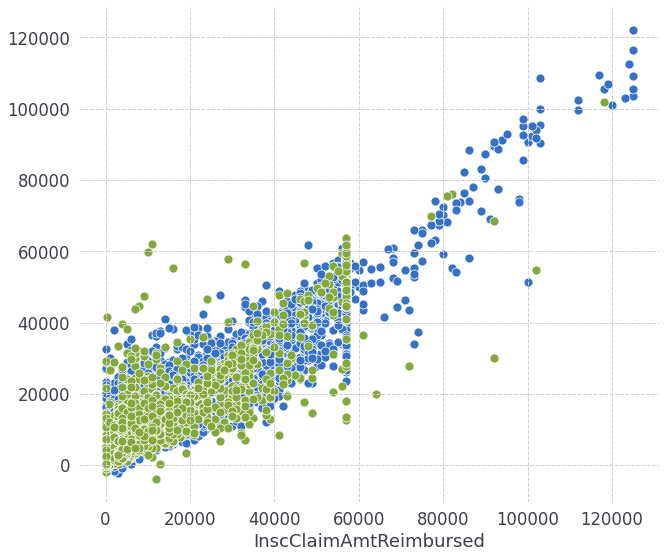

In [237]:
# plot relations between true values and predicts

sns.scatterplot(x=y_train, y=model.predict(train_pool))
sns.scatterplot(x=y_test, y=model.predict(test_pool))

#### 3.1.2 InscClaimAmtReimbursed for outpatient

In [239]:
cat_features = [x for i, x in enumerate(reg_data) if i not in [5, 6, 18, 19, 20, 21, 25, 24]]

X_train, X_test, y_train, y_test = train_test_split(reg_outp, lab2_outp, test_size=0.1)

X_train[cat_features] = X_train[cat_features].astype(int).copy()
X_test[cat_features] = X_test[cat_features].astype(int).copy()

/home/misery7100/Programs/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
train_pool = ctb.Pool(X_train, y_train, cat_features=cat_features)
test_pool = ctb.Pool(X_test, y_test, cat_features=cat_features)

model = ctb.CatBoostRegressor(

        iterations=2000,
        learning_rate=0.05,
        depth=7,
        loss_function='RMSE'

    )

model.fit(train_pool)
preds = model.predict(test_pool)

0:	learn: 670.2320585	total: 164ms	remaining: 5m 28s
1:	learn: 661.8354933	total: 349ms	remaining: 5m 48s
2:	learn: 654.1647842	total: 492ms	remaining: 5m 27s
3:	learn: 647.6179124	total: 673ms	remaining: 5m 35s
4:	learn: 640.7818742	total: 835ms	remaining: 5m 33s
5:	learn: 634.4437341	total: 1s	remaining: 5m 33s
6:	learn: 629.7638399	total: 1.17s	remaining: 5m 34s
7:	learn: 624.1090344	total: 1.34s	remaining: 5m 32s
8:	learn: 619.4851056	total: 1.5s	remaining: 5m 31s
9:	learn: 616.0546413	total: 1.65s	remaining: 5m 28s
10:	learn: 612.3657745	total: 1.8s	remaining: 5m 26s
11:	learn: 607.9726305	total: 1.95s	remaining: 5m 22s
12:	learn: 603.8867276	total: 2.07s	remaining: 5m 16s
13:	learn: 599.8971315	total: 2.22s	remaining: 5m 14s
14:	learn: 597.3609600	total: 2.38s	remaining: 5m 14s
15:	learn: 594.4661950	total: 2.53s	remaining: 5m 13s
16:	learn: 591.1336169	total: 2.69s	remaining: 5m 13s
17:	learn: 588.4007674	total: 2.83s	remaining: 5m 11s
18:	learn: 586.6761711	total: 2.98s	remaini

152:	learn: 520.0370510	total: 22.4s	remaining: 4m 30s
153:	learn: 519.8682878	total: 22.6s	remaining: 4m 30s
154:	learn: 519.7895179	total: 22.7s	remaining: 4m 30s
155:	learn: 519.6874498	total: 22.9s	remaining: 4m 30s
156:	learn: 519.5648513	total: 23s	remaining: 4m 29s
157:	learn: 519.4975012	total: 23.2s	remaining: 4m 29s
158:	learn: 519.4404281	total: 23.3s	remaining: 4m 29s
159:	learn: 519.3652114	total: 23.5s	remaining: 4m 29s
160:	learn: 519.0822704	total: 23.6s	remaining: 4m 29s
161:	learn: 518.9740293	total: 23.8s	remaining: 4m 30s
162:	learn: 518.9149331	total: 23.9s	remaining: 4m 29s
163:	learn: 518.7498093	total: 24.1s	remaining: 4m 29s
164:	learn: 518.6002087	total: 24.2s	remaining: 4m 29s
165:	learn: 518.5092005	total: 24.3s	remaining: 4m 28s
166:	learn: 518.1788183	total: 24.5s	remaining: 4m 28s
167:	learn: 518.1136184	total: 24.7s	remaining: 4m 28s
168:	learn: 518.0416681	total: 24.8s	remaining: 4m 28s
169:	learn: 517.9674573	total: 24.9s	remaining: 4m 28s
170:	learn: 

303:	learn: 506.1862237	total: 44.4s	remaining: 4m 7s
304:	learn: 506.1500119	total: 44.6s	remaining: 4m 7s
305:	learn: 506.0987847	total: 44.8s	remaining: 4m 7s
306:	learn: 505.9885602	total: 44.9s	remaining: 4m 7s
307:	learn: 505.9370889	total: 45s	remaining: 4m 7s
308:	learn: 505.8492572	total: 45.2s	remaining: 4m 7s
309:	learn: 505.7700805	total: 45.4s	remaining: 4m 7s
310:	learn: 505.7012578	total: 45.5s	remaining: 4m 7s
311:	learn: 505.6742586	total: 45.7s	remaining: 4m 7s
312:	learn: 505.6201835	total: 45.8s	remaining: 4m 6s
313:	learn: 505.5400659	total: 45.9s	remaining: 4m 6s
314:	learn: 505.5123454	total: 46.1s	remaining: 4m 6s
315:	learn: 505.4391223	total: 46.2s	remaining: 4m 6s
316:	learn: 505.4000668	total: 46.3s	remaining: 4m 5s
317:	learn: 505.2887253	total: 46.5s	remaining: 4m 5s
318:	learn: 505.2232236	total: 46.6s	remaining: 4m 5s
319:	learn: 505.1685190	total: 46.8s	remaining: 4m 5s
320:	learn: 505.1402359	total: 46.9s	remaining: 4m 5s
321:	learn: 505.0862512	total:

455:	learn: 499.2725308	total: 1m 4s	remaining: 3m 37s
456:	learn: 499.2391918	total: 1m 4s	remaining: 3m 37s
457:	learn: 499.2261754	total: 1m 4s	remaining: 3m 37s
458:	learn: 499.1884215	total: 1m 4s	remaining: 3m 36s
459:	learn: 499.1301534	total: 1m 4s	remaining: 3m 36s
460:	learn: 499.0837004	total: 1m 4s	remaining: 3m 36s
461:	learn: 499.0515584	total: 1m 4s	remaining: 3m 36s
462:	learn: 499.0318334	total: 1m 5s	remaining: 3m 36s
463:	learn: 499.0005683	total: 1m 5s	remaining: 3m 35s
464:	learn: 498.9620079	total: 1m 5s	remaining: 3m 35s
465:	learn: 498.9312422	total: 1m 5s	remaining: 3m 35s
466:	learn: 498.9028352	total: 1m 5s	remaining: 3m 35s
467:	learn: 498.8722040	total: 1m 5s	remaining: 3m 35s
468:	learn: 498.8119315	total: 1m 5s	remaining: 3m 34s
469:	learn: 498.7837517	total: 1m 5s	remaining: 3m 34s
470:	learn: 498.7338477	total: 1m 6s	remaining: 3m 34s
471:	learn: 498.7083773	total: 1m 6s	remaining: 3m 34s
472:	learn: 498.6898388	total: 1m 6s	remaining: 3m 34s
473:	learn

603:	learn: 494.7838590	total: 1m 24s	remaining: 3m 15s
604:	learn: 494.7270839	total: 1m 24s	remaining: 3m 15s
605:	learn: 494.6978645	total: 1m 25s	remaining: 3m 15s
606:	learn: 494.6555999	total: 1m 25s	remaining: 3m 15s
607:	learn: 494.6124182	total: 1m 25s	remaining: 3m 15s
608:	learn: 494.6012109	total: 1m 25s	remaining: 3m 15s
609:	learn: 494.5778239	total: 1m 25s	remaining: 3m 15s
610:	learn: 494.5370567	total: 1m 25s	remaining: 3m 14s
611:	learn: 494.5073479	total: 1m 25s	remaining: 3m 14s
612:	learn: 494.4969838	total: 1m 25s	remaining: 3m 14s
613:	learn: 494.4463646	total: 1m 26s	remaining: 3m 14s
614:	learn: 494.4257950	total: 1m 26s	remaining: 3m 14s
615:	learn: 494.4082384	total: 1m 26s	remaining: 3m 14s
616:	learn: 494.3657259	total: 1m 26s	remaining: 3m 13s
617:	learn: 494.3305500	total: 1m 26s	remaining: 3m 13s
618:	learn: 494.3131152	total: 1m 26s	remaining: 3m 13s
619:	learn: 494.2890962	total: 1m 26s	remaining: 3m 13s
620:	learn: 494.2628580	total: 1m 27s	remaining:

In [ ]:
# plot relations between true values and predicts

sns.scatterplot(x=y_train, y=model.predict(train_pool))
sns.scatterplot(x=y_test, y=model.predict(test_pool))

#### 3.1.3 DeductibleAmtPaid for outpatient

In [ ]:
cat_features = [x for i, x in enumerate(reg_data) if i not in [5, 6, 18, 19, 20, 21, 25, 24]]

X_train, X_test, y_train, y_test = train_test_split(reg_outp, lab1_outp, test_size=0.1)

X_train[cat_features] = X_train[cat_features].astype(int).copy()
X_test[cat_features] = X_test[cat_features].astype(int).copy()

In [ ]:
train_pool = ctb.Pool(X_train, y_train, cat_features=cat_features)
test_pool = ctb.Pool(X_test, y_test, cat_features=cat_features)

model = ctb.CatBoostRegressor(

        iterations=2000,
        learning_rate=0.05,
        depth=7,
        loss_function='RMSE'

    )

model.fit(train_pool)
preds = model.predict(test_pool)

In [ ]:
# plot relations between true values and predicts

sns.scatterplot(x=y_train, y=model.predict(train_pool))
sns.scatterplot(x=y_test, y=model.predict(test_pool))

### 3.2 Classification

In [84]:
train_supl = train_merged.copy()

# for patient statistics
train_supl['death'] = train_supl.DOD.apply(lambda x: str(x) != 'nan')
train_supl['Age'] = (train_supl.ClaimStartDt - train_supl.DOB).apply(lambda x: x.days // 365)
train_supl['ClaimDuration'] = (train_supl.ClaimEndDt - train_supl.ClaimStartDt).apply(lambda x: x.days)

embed_cols = copy(cond_cols)

# build provider embeddings
for dcode, _ in tqdm(diags_counts[:100]):
    
    train_supl[f'diag_{dcode}'] = (train_supl[diag_cols] == dcode).sum(1).astype(bool)
    embed_cols.append(f'diag_{dcode}')

for pcode, _ in tqdm(procs_counts[:100]):
    
    train_supl[f'proc_{pcode}'] = (train_supl[proc_cols] == pcode).sum(1).astype(bool)
    embed_cols.append(f'proc_{pcode}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Drop unnecessary columns

In [85]:
train_supl.drop(to_drop_cols, axis=1, inplace=True)

Calculate stored dicts related to clustering

In [93]:
# let it be
precond_clust_dict = dict(precond_clust_dict)
diag_clust_dict = dict(diag_clust_dict)
proc_clust_dict = dict(proc_clust_dict)

Build dataset for classification

In [134]:
cl_data = (train_supl[embed_cols + ['Provider']]
           .groupby('Provider')
           .sum()
           .reset_index()
          )

cl_data['clust_cond'] = cl_data.Provider.apply(lambda x: precond_clust_dict.get(x, -1))
cl_data['clust_diag'] = cl_data.Provider.apply(lambda x: diag_clust_dict.get(x, -1))
cl_data['clust_proc'] = cl_data.Provider.apply(lambda x: proc_clust_dict.get(x, -1))
cl_data['patients'] = cl_data.Provider.apply(lambda x: provider_patients.get(x, 0))
cl_data['neighbours'] = cl_data.Provider.apply(lambda x: provider_neighbours.get(x, 0))

median_cols = ['State', 'County']

cl_data[median_cols] = train_supl.groupby('Provider')[median_cols].median().reset_index(drop=True)

mean_cols = [
    'NoOfMonths_PartACov',
    'NoOfMonths_PartBCov', 
    'IPAnnualReimbursementAmt', 
    'IPAnnualDeductibleAmt',
    'OPAnnualReimbursementAmt',
    'OPAnnualDeductibleAmt',
    'InscClaimAmtReimbursed'
]

cl_data[mean_cols] = train_supl.groupby('Provider')[mean_cols].mean().reset_index(drop=True)

cl_data

,Provider,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,...,neighbours,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,InscClaimAmtReimbursed
0,PRV51001,10,6,8,20,15,16,4,2,19,...,32,1.0,440.0,12.000000,12.000000,17606.000000,897.120000,2615.200000,463.920000,4185.600000
1,PRV51003,76,52,68,122,91,78,32,20,99,...,86,1.0,330.0,11.818182,11.871212,7568.181818,931.424242,2678.181818,737.121212,4588.409091
2,PRV51004,85,61,99,133,108,86,44,41,100,...,144,1.0,360.0,11.865772,11.959732,4351.879195,434.953020,2194.899329,622.751678,350.134228
3,PRV51005,739,485,658,1000,870,680,366,270,821,...,106,1.0,510.0,11.907296,11.939914,3623.991416,379.162232,2109.733906,636.328755,241.124464
4,PRV51007,46,32,50,60,56,43,23,21,51,...,45,1.0,380.0,11.833333,11.833333,3050.000000,445.000000,1729.722222,469.722222,468.194444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,14,8,13,24,17,19,8,0,15,...,19,45.0,120.0,12.000000,12.000000,3962.142857,457.714286,3241.785714,886.785714,380.000000
5406,PRV57760,19,11,20,22,20,15,4,0,11,...,5,45.0,292.0,12.000000,11.727273,2785.454545,436.909091,1492.727273,805.454545,216.818182
5407,PRV57761,46,26,42,68,52,44,27,20,50,...,114,10.0,410.0,12.000000,12.000000,7026.585366,586.097561,2928.414634,707.317073,225.243902
5408,PRV57762,1,1,0,0,0,1,0,0,1,...,2,21.0,230.0,12.000000,12.000000,15000.000000,1068.000000,2540.000000,400.000000,1900.000000


In [135]:
cl_data = cl_data.merge(train, on='Provider')
cl_data.drop('Provider', inplace=True, axis=1)
cl_data.PotentialFraud = cl_data.PotentialFraud.apply(lambda x: x == 'Yes').astype(int)

cl_data.PotentialFraud.value_counts()

0    4904
1     506
Name: PotentialFraud, dtype: int64

Two variants dealing with imbalanced data: oversampling minor class and undersampling major class. For that `imblearn` package is used

In [137]:
# oversampling

X, y = cl_data.drop('PotentialFraud', axis=1).copy(), cl_data.PotentialFraud.copy()
X_over, y_over = ADASYN().fit_resample(X, y)

In [138]:
# undersampling

cc = ClusterCentroids(random_state=0)
X_under, y_under = cc.fit_resample(X, y)

#### 3.2.1 Oversampled data

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over)

# specify categorical features for catboost
cat_features = embed_cols + ['State', 'County', 'clust_cond', 'clust_diag', 'clust_proc']

X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

/home/misery7100/Programs/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [151]:
from sklearn.metrics import recall_score, precision_score

train_pool = ctb.Pool(X_train, y_train, cat_features=cat_features)
test_pool = ctb.Pool(X_test, y_test, cat_features=cat_features)

model = ctb.CatBoostClassifier(

        iterations=2000,
        learning_rate=0.05,
        depth=4,

    )

model.fit(train_pool)
preds = model.predict(test_pool)

0:	learn: 0.6390777	total: 38.9ms	remaining: 1m 17s
1:	learn: 0.5955867	total: 79.9ms	remaining: 1m 19s
2:	learn: 0.5589101	total: 113ms	remaining: 1m 15s
3:	learn: 0.5022016	total: 154ms	remaining: 1m 16s
4:	learn: 0.4613013	total: 192ms	remaining: 1m 16s
5:	learn: 0.4246360	total: 233ms	remaining: 1m 17s
6:	learn: 0.3953864	total: 283ms	remaining: 1m 20s
7:	learn: 0.3643722	total: 338ms	remaining: 1m 24s
8:	learn: 0.3400648	total: 384ms	remaining: 1m 24s
9:	learn: 0.3237860	total: 428ms	remaining: 1m 25s
10:	learn: 0.3084822	total: 472ms	remaining: 1m 25s
11:	learn: 0.2952361	total: 528ms	remaining: 1m 27s
12:	learn: 0.2818507	total: 581ms	remaining: 1m 28s
13:	learn: 0.2708172	total: 631ms	remaining: 1m 29s
14:	learn: 0.2624287	total: 679ms	remaining: 1m 29s
15:	learn: 0.2559287	total: 725ms	remaining: 1m 29s
16:	learn: 0.2481029	total: 773ms	remaining: 1m 30s
17:	learn: 0.2424299	total: 814ms	remaining: 1m 29s
18:	learn: 0.2372319	total: 856ms	remaining: 1m 29s
19:	learn: 0.2341175

160:	learn: 0.1435213	total: 6.67s	remaining: 1m 16s
161:	learn: 0.1432581	total: 6.71s	remaining: 1m 16s
162:	learn: 0.1429785	total: 6.75s	remaining: 1m 16s
163:	learn: 0.1427460	total: 6.78s	remaining: 1m 15s
164:	learn: 0.1424723	total: 6.82s	remaining: 1m 15s
165:	learn: 0.1424579	total: 6.85s	remaining: 1m 15s
166:	learn: 0.1422583	total: 6.88s	remaining: 1m 15s
167:	learn: 0.1419673	total: 6.93s	remaining: 1m 15s
168:	learn: 0.1417658	total: 6.96s	remaining: 1m 15s
169:	learn: 0.1416023	total: 7s	remaining: 1m 15s
170:	learn: 0.1414677	total: 7.04s	remaining: 1m 15s
171:	learn: 0.1414677	total: 7.07s	remaining: 1m 15s
172:	learn: 0.1414514	total: 7.11s	remaining: 1m 15s
173:	learn: 0.1414190	total: 7.14s	remaining: 1m 14s
174:	learn: 0.1414094	total: 7.18s	remaining: 1m 14s
175:	learn: 0.1411828	total: 7.21s	remaining: 1m 14s
176:	learn: 0.1411661	total: 7.24s	remaining: 1m 14s
177:	learn: 0.1408733	total: 7.27s	remaining: 1m 14s
178:	learn: 0.1407735	total: 7.3s	remaining: 1m 1

317:	learn: 0.1249950	total: 12.8s	remaining: 1m 7s
318:	learn: 0.1249152	total: 12.9s	remaining: 1m 7s
319:	learn: 0.1248443	total: 12.9s	remaining: 1m 7s
320:	learn: 0.1247205	total: 12.9s	remaining: 1m 7s
321:	learn: 0.1244567	total: 13s	remaining: 1m 7s
322:	learn: 0.1244411	total: 13s	remaining: 1m 7s
323:	learn: 0.1242448	total: 13.1s	remaining: 1m 7s
324:	learn: 0.1242377	total: 13.1s	remaining: 1m 7s
325:	learn: 0.1239156	total: 13.1s	remaining: 1m 7s
326:	learn: 0.1238505	total: 13.2s	remaining: 1m 7s
327:	learn: 0.1238492	total: 13.2s	remaining: 1m 7s
328:	learn: 0.1238168	total: 13.2s	remaining: 1m 7s
329:	learn: 0.1238119	total: 13.3s	remaining: 1m 7s
330:	learn: 0.1236227	total: 13.3s	remaining: 1m 7s
331:	learn: 0.1234312	total: 13.3s	remaining: 1m 7s
332:	learn: 0.1232092	total: 13.4s	remaining: 1m 7s
333:	learn: 0.1230343	total: 13.4s	remaining: 1m 6s
334:	learn: 0.1227921	total: 13.5s	remaining: 1m 6s
335:	learn: 0.1227730	total: 13.5s	remaining: 1m 6s
336:	learn: 0.12

478:	learn: 0.1085598	total: 19.1s	remaining: 1m
479:	learn: 0.1085507	total: 19.2s	remaining: 1m
480:	learn: 0.1085502	total: 19.2s	remaining: 1m
481:	learn: 0.1083558	total: 19.2s	remaining: 1m
482:	learn: 0.1083464	total: 19.3s	remaining: 1m
483:	learn: 0.1081575	total: 19.3s	remaining: 1m
484:	learn: 0.1081560	total: 19.3s	remaining: 1m
485:	learn: 0.1079789	total: 19.4s	remaining: 1m
486:	learn: 0.1079737	total: 19.4s	remaining: 1m
487:	learn: 0.1079393	total: 19.4s	remaining: 1m
488:	learn: 0.1079311	total: 19.5s	remaining: 1m
489:	learn: 0.1078729	total: 19.5s	remaining: 1m
490:	learn: 0.1076808	total: 19.6s	remaining: 1m
491:	learn: 0.1076785	total: 19.6s	remaining: 1m
492:	learn: 0.1076780	total: 19.6s	remaining: 1m
493:	learn: 0.1076686	total: 19.7s	remaining: 1m
494:	learn: 0.1076599	total: 19.7s	remaining: 60s
495:	learn: 0.1076559	total: 19.8s	remaining: 60s
496:	learn: 0.1075596	total: 19.8s	remaining: 59.9s
497:	learn: 0.1075574	total: 19.9s	remaining: 59.9s
498:	learn: 

640:	learn: 0.1003685	total: 25.5s	remaining: 54.1s
641:	learn: 0.1003621	total: 25.5s	remaining: 54s
642:	learn: 0.1003239	total: 25.6s	remaining: 54s
643:	learn: 0.1003228	total: 25.6s	remaining: 53.9s
644:	learn: 0.1003018	total: 25.7s	remaining: 53.9s
645:	learn: 0.1003002	total: 25.7s	remaining: 53.8s
646:	learn: 0.1002206	total: 25.7s	remaining: 53.8s
647:	learn: 0.1001761	total: 25.8s	remaining: 53.8s
648:	learn: 0.0999534	total: 25.8s	remaining: 53.8s
649:	learn: 0.0997818	total: 25.9s	remaining: 53.7s
650:	learn: 0.0997767	total: 25.9s	remaining: 53.7s
651:	learn: 0.0996687	total: 26s	remaining: 53.7s
652:	learn: 0.0996250	total: 26s	remaining: 53.6s
653:	learn: 0.0995175	total: 26s	remaining: 53.6s
654:	learn: 0.0995023	total: 26.1s	remaining: 53.5s
655:	learn: 0.0994727	total: 26.1s	remaining: 53.5s
656:	learn: 0.0994362	total: 26.1s	remaining: 53.5s
657:	learn: 0.0994340	total: 26.2s	remaining: 53.4s
658:	learn: 0.0993737	total: 26.2s	remaining: 53.4s
659:	learn: 0.0992344	

801:	learn: 0.0902724	total: 32.5s	remaining: 48.5s
802:	learn: 0.0902552	total: 32.5s	remaining: 48.5s
803:	learn: 0.0902549	total: 32.5s	remaining: 48.4s
804:	learn: 0.0902477	total: 32.6s	remaining: 48.4s
805:	learn: 0.0901838	total: 32.6s	remaining: 48.3s
806:	learn: 0.0901558	total: 32.7s	remaining: 48.3s
807:	learn: 0.0900916	total: 32.7s	remaining: 48.3s
808:	learn: 0.0899711	total: 32.8s	remaining: 48.2s
809:	learn: 0.0899031	total: 32.8s	remaining: 48.2s
810:	learn: 0.0899031	total: 32.9s	remaining: 48.2s
811:	learn: 0.0898587	total: 32.9s	remaining: 48.2s
812:	learn: 0.0898254	total: 33s	remaining: 48.1s
813:	learn: 0.0897627	total: 33s	remaining: 48.1s
814:	learn: 0.0897245	total: 33.1s	remaining: 48.1s
815:	learn: 0.0897051	total: 33.1s	remaining: 48s
816:	learn: 0.0896710	total: 33.1s	remaining: 48s
817:	learn: 0.0896508	total: 33.2s	remaining: 47.9s
818:	learn: 0.0896498	total: 33.2s	remaining: 47.9s
819:	learn: 0.0896237	total: 33.2s	remaining: 47.8s
820:	learn: 0.089618

960:	learn: 0.0828381	total: 39.4s	remaining: 42.6s
961:	learn: 0.0828032	total: 39.5s	remaining: 42.6s
962:	learn: 0.0826929	total: 39.5s	remaining: 42.5s
963:	learn: 0.0826706	total: 39.6s	remaining: 42.5s
964:	learn: 0.0826693	total: 39.6s	remaining: 42.5s
965:	learn: 0.0825572	total: 39.6s	remaining: 42.4s
966:	learn: 0.0825056	total: 39.7s	remaining: 42.4s
967:	learn: 0.0824992	total: 39.8s	remaining: 42.4s
968:	learn: 0.0824990	total: 39.8s	remaining: 42.4s
969:	learn: 0.0824651	total: 39.9s	remaining: 42.3s
970:	learn: 0.0824303	total: 39.9s	remaining: 42.3s
971:	learn: 0.0823493	total: 39.9s	remaining: 42.2s
972:	learn: 0.0822878	total: 40s	remaining: 42.2s
973:	learn: 0.0822156	total: 40s	remaining: 42.2s
974:	learn: 0.0821490	total: 40.1s	remaining: 42.1s
975:	learn: 0.0821264	total: 40.1s	remaining: 42.1s
976:	learn: 0.0820682	total: 40.2s	remaining: 42.1s
977:	learn: 0.0820662	total: 40.2s	remaining: 42s
978:	learn: 0.0820646	total: 40.3s	remaining: 42s
979:	learn: 0.081926

1119:	learn: 0.0762069	total: 46.5s	remaining: 36.5s
1120:	learn: 0.0760527	total: 46.5s	remaining: 36.5s
1121:	learn: 0.0760526	total: 46.6s	remaining: 36.4s
1122:	learn: 0.0759865	total: 46.6s	remaining: 36.4s
1123:	learn: 0.0759501	total: 46.6s	remaining: 36.4s
1124:	learn: 0.0759487	total: 46.7s	remaining: 36.3s
1125:	learn: 0.0759209	total: 46.7s	remaining: 36.3s
1126:	learn: 0.0759171	total: 46.8s	remaining: 36.2s
1127:	learn: 0.0758534	total: 46.8s	remaining: 36.2s
1128:	learn: 0.0758471	total: 46.9s	remaining: 36.1s
1129:	learn: 0.0758471	total: 46.9s	remaining: 36.1s
1130:	learn: 0.0758427	total: 46.9s	remaining: 36.1s
1131:	learn: 0.0757880	total: 47s	remaining: 36s
1132:	learn: 0.0757869	total: 47s	remaining: 36s
1133:	learn: 0.0757469	total: 47.1s	remaining: 35.9s
1134:	learn: 0.0756567	total: 47.1s	remaining: 35.9s
1135:	learn: 0.0756243	total: 47.1s	remaining: 35.9s
1136:	learn: 0.0755458	total: 47.2s	remaining: 35.8s
1137:	learn: 0.0754326	total: 47.2s	remaining: 35.8s
1

1275:	learn: 0.0699827	total: 53.2s	remaining: 30.2s
1276:	learn: 0.0699632	total: 53.3s	remaining: 30.2s
1277:	learn: 0.0698427	total: 53.3s	remaining: 30.1s
1278:	learn: 0.0698419	total: 53.4s	remaining: 30.1s
1279:	learn: 0.0698387	total: 53.4s	remaining: 30s
1280:	learn: 0.0697878	total: 53.4s	remaining: 30s
1281:	learn: 0.0697835	total: 53.5s	remaining: 30s
1282:	learn: 0.0697187	total: 53.5s	remaining: 29.9s
1283:	learn: 0.0697121	total: 53.6s	remaining: 29.9s
1284:	learn: 0.0696705	total: 53.6s	remaining: 29.8s
1285:	learn: 0.0696554	total: 53.6s	remaining: 29.8s
1286:	learn: 0.0696532	total: 53.7s	remaining: 29.7s
1287:	learn: 0.0695432	total: 53.7s	remaining: 29.7s
1288:	learn: 0.0695432	total: 53.8s	remaining: 29.7s
1289:	learn: 0.0695303	total: 53.8s	remaining: 29.6s
1290:	learn: 0.0695297	total: 53.8s	remaining: 29.6s
1291:	learn: 0.0695219	total: 53.9s	remaining: 29.5s
1292:	learn: 0.0695141	total: 53.9s	remaining: 29.5s
1293:	learn: 0.0694846	total: 54s	remaining: 29.4s
1

1432:	learn: 0.0651218	total: 59.7s	remaining: 23.6s
1433:	learn: 0.0651153	total: 59.8s	remaining: 23.6s
1434:	learn: 0.0651101	total: 59.8s	remaining: 23.6s
1435:	learn: 0.0650468	total: 59.9s	remaining: 23.5s
1436:	learn: 0.0650269	total: 59.9s	remaining: 23.5s
1437:	learn: 0.0650045	total: 59.9s	remaining: 23.4s
1438:	learn: 0.0648931	total: 60s	remaining: 23.4s
1439:	learn: 0.0648915	total: 1m	remaining: 23.3s
1440:	learn: 0.0648630	total: 1m	remaining: 23.3s
1441:	learn: 0.0648619	total: 1m	remaining: 23.3s
1442:	learn: 0.0648619	total: 1m	remaining: 23.2s
1443:	learn: 0.0647898	total: 1m	remaining: 23.2s
1444:	learn: 0.0647651	total: 1m	remaining: 23.2s
1445:	learn: 0.0647634	total: 1m	remaining: 23.1s
1446:	learn: 0.0646688	total: 1m	remaining: 23.1s
1447:	learn: 0.0646576	total: 1m	remaining: 23.1s
1448:	learn: 0.0645896	total: 1m	remaining: 23s
1449:	learn: 0.0645351	total: 1m	remaining: 23s
1450:	learn: 0.0644545	total: 1m	remaining: 22.9s
1451:	learn: 0.0644279	total: 1m	re

1592:	learn: 0.0603189	total: 1m 6s	remaining: 17s
1593:	learn: 0.0602841	total: 1m 6s	remaining: 16.9s
1594:	learn: 0.0602196	total: 1m 6s	remaining: 16.9s
1595:	learn: 0.0601588	total: 1m 6s	remaining: 16.9s
1596:	learn: 0.0601389	total: 1m 6s	remaining: 16.8s
1597:	learn: 0.0601218	total: 1m 6s	remaining: 16.8s
1598:	learn: 0.0601201	total: 1m 6s	remaining: 16.7s
1599:	learn: 0.0601200	total: 1m 6s	remaining: 16.7s
1600:	learn: 0.0601144	total: 1m 6s	remaining: 16.7s
1601:	learn: 0.0601062	total: 1m 6s	remaining: 16.6s
1602:	learn: 0.0601049	total: 1m 6s	remaining: 16.6s
1603:	learn: 0.0600971	total: 1m 6s	remaining: 16.5s
1604:	learn: 0.0600464	total: 1m 6s	remaining: 16.5s
1605:	learn: 0.0600452	total: 1m 7s	remaining: 16.4s
1606:	learn: 0.0600330	total: 1m 7s	remaining: 16.4s
1607:	learn: 0.0599987	total: 1m 7s	remaining: 16.4s
1608:	learn: 0.0599360	total: 1m 7s	remaining: 16.3s
1609:	learn: 0.0599268	total: 1m 7s	remaining: 16.3s
1610:	learn: 0.0598782	total: 1m 7s	remaining: 1

1749:	learn: 0.0563577	total: 1m 12s	remaining: 10.4s
1750:	learn: 0.0563577	total: 1m 12s	remaining: 10.4s
1751:	learn: 0.0563552	total: 1m 12s	remaining: 10.3s
1752:	learn: 0.0563169	total: 1m 12s	remaining: 10.3s
1753:	learn: 0.0563141	total: 1m 12s	remaining: 10.2s
1754:	learn: 0.0563118	total: 1m 12s	remaining: 10.2s
1755:	learn: 0.0562895	total: 1m 12s	remaining: 10.1s
1756:	learn: 0.0562689	total: 1m 13s	remaining: 10.1s
1757:	learn: 0.0562452	total: 1m 13s	remaining: 10.1s
1758:	learn: 0.0562414	total: 1m 13s	remaining: 10s
1759:	learn: 0.0561694	total: 1m 13s	remaining: 9.97s
1760:	learn: 0.0561068	total: 1m 13s	remaining: 9.93s
1761:	learn: 0.0560397	total: 1m 13s	remaining: 9.89s
1762:	learn: 0.0559989	total: 1m 13s	remaining: 9.85s
1763:	learn: 0.0559721	total: 1m 13s	remaining: 9.81s
1764:	learn: 0.0559632	total: 1m 13s	remaining: 9.77s
1765:	learn: 0.0559549	total: 1m 13s	remaining: 9.72s
1766:	learn: 0.0559490	total: 1m 13s	remaining: 9.68s
1767:	learn: 0.0559239	total: 

1907:	learn: 0.0526329	total: 1m 19s	remaining: 3.81s
1908:	learn: 0.0525922	total: 1m 19s	remaining: 3.77s
1909:	learn: 0.0525370	total: 1m 19s	remaining: 3.73s
1910:	learn: 0.0525292	total: 1m 19s	remaining: 3.69s
1911:	learn: 0.0525292	total: 1m 19s	remaining: 3.65s
1912:	learn: 0.0525188	total: 1m 19s	remaining: 3.6s
1913:	learn: 0.0524735	total: 1m 19s	remaining: 3.56s
1914:	learn: 0.0524734	total: 1m 19s	remaining: 3.52s
1915:	learn: 0.0524619	total: 1m 19s	remaining: 3.48s
1916:	learn: 0.0524619	total: 1m 19s	remaining: 3.44s
1917:	learn: 0.0524588	total: 1m 19s	remaining: 3.4s
1918:	learn: 0.0524497	total: 1m 19s	remaining: 3.35s
1919:	learn: 0.0524336	total: 1m 19s	remaining: 3.31s
1920:	learn: 0.0524219	total: 1m 19s	remaining: 3.27s
1921:	learn: 0.0523888	total: 1m 19s	remaining: 3.23s
1922:	learn: 0.0523495	total: 1m 19s	remaining: 3.19s
1923:	learn: 0.0523463	total: 1m 19s	remaining: 3.15s
1924:	learn: 0.0523462	total: 1m 19s	remaining: 3.11s
1925:	learn: 0.0522837	total: 

Text(0.5, 1.0, 'Test ROC_AUC: 0.9617476112026359')

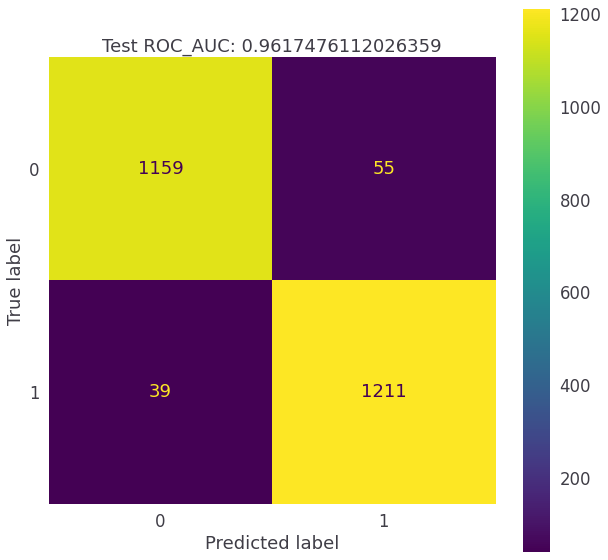

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(model, X_test, y_test, ax=ax)

ax.grid(False)
ax.set_title(f'Test ROC_AUC: {roc_auc_score(y_test, preds)}')

#### 3.2.2 Undersampled data

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under)

# specify categorical features for catboost
cat_features = embed_cols + ['State', 'County', 'clust_cond', 'clust_diag', 'clust_proc']

X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

/home/misery7100/Programs/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [156]:
from sklearn.metrics import recall_score, precision_score

train_pool = ctb.Pool(X_train, y_train, cat_features=cat_features)
test_pool = ctb.Pool(X_test, y_test, cat_features=cat_features)

model = ctb.CatBoostClassifier(

        iterations=1000,
        learning_rate=0.05,
        depth=4,

    )

model.fit(train_pool)
preds = model.predict(test_pool)

0:	learn: 0.6434688	total: 15.7ms	remaining: 15.7s
1:	learn: 0.6054635	total: 30ms	remaining: 15s
2:	learn: 0.5669422	total: 48.3ms	remaining: 16.1s
3:	learn: 0.5323781	total: 66.7ms	remaining: 16.6s
4:	learn: 0.5014376	total: 83.6ms	remaining: 16.6s
5:	learn: 0.4749377	total: 95.1ms	remaining: 15.8s
6:	learn: 0.4481481	total: 106ms	remaining: 15.1s
7:	learn: 0.4263278	total: 117ms	remaining: 14.6s
8:	learn: 0.4092463	total: 129ms	remaining: 14.2s
9:	learn: 0.3921058	total: 141ms	remaining: 13.9s
10:	learn: 0.3779444	total: 152ms	remaining: 13.6s
11:	learn: 0.3615974	total: 163ms	remaining: 13.4s
12:	learn: 0.3473426	total: 175ms	remaining: 13.3s
13:	learn: 0.3340572	total: 187ms	remaining: 13.1s
14:	learn: 0.3231422	total: 198ms	remaining: 13s
15:	learn: 0.3125834	total: 209ms	remaining: 12.9s
16:	learn: 0.3030869	total: 221ms	remaining: 12.8s
17:	learn: 0.2960883	total: 234ms	remaining: 12.7s
18:	learn: 0.2903537	total: 249ms	remaining: 12.9s
19:	learn: 0.2832404	total: 266ms	remaini

169:	learn: 0.0941604	total: 2.51s	remaining: 12.2s
170:	learn: 0.0939022	total: 2.52s	remaining: 12.2s
171:	learn: 0.0934933	total: 2.54s	remaining: 12.2s
172:	learn: 0.0923188	total: 2.56s	remaining: 12.3s
173:	learn: 0.0921741	total: 2.58s	remaining: 12.3s
174:	learn: 0.0920957	total: 2.6s	remaining: 12.3s
175:	learn: 0.0912651	total: 2.62s	remaining: 12.3s
176:	learn: 0.0911510	total: 2.64s	remaining: 12.3s
177:	learn: 0.0910015	total: 2.65s	remaining: 12.2s
178:	learn: 0.0909907	total: 2.67s	remaining: 12.2s
179:	learn: 0.0905540	total: 2.68s	remaining: 12.2s
180:	learn: 0.0904889	total: 2.69s	remaining: 12.2s
181:	learn: 0.0904888	total: 2.71s	remaining: 12.2s
182:	learn: 0.0900004	total: 2.72s	remaining: 12.2s
183:	learn: 0.0899130	total: 2.74s	remaining: 12.1s
184:	learn: 0.0889988	total: 2.75s	remaining: 12.1s
185:	learn: 0.0887032	total: 2.77s	remaining: 12.1s
186:	learn: 0.0886990	total: 2.79s	remaining: 12.1s
187:	learn: 0.0886950	total: 2.8s	remaining: 12.1s
188:	learn: 0.

332:	learn: 0.0593553	total: 5.24s	remaining: 10.5s
333:	learn: 0.0587924	total: 5.25s	remaining: 10.5s
334:	learn: 0.0587908	total: 5.27s	remaining: 10.5s
335:	learn: 0.0587908	total: 5.28s	remaining: 10.4s
336:	learn: 0.0587849	total: 5.3s	remaining: 10.4s
337:	learn: 0.0586570	total: 5.32s	remaining: 10.4s
338:	learn: 0.0585629	total: 5.34s	remaining: 10.4s
339:	learn: 0.0583964	total: 5.35s	remaining: 10.4s
340:	learn: 0.0583964	total: 5.37s	remaining: 10.4s
341:	learn: 0.0583925	total: 5.38s	remaining: 10.4s
342:	learn: 0.0580536	total: 5.4s	remaining: 10.3s
343:	learn: 0.0578572	total: 5.41s	remaining: 10.3s
344:	learn: 0.0577629	total: 5.42s	remaining: 10.3s
345:	learn: 0.0576772	total: 5.44s	remaining: 10.3s
346:	learn: 0.0575195	total: 5.46s	remaining: 10.3s
347:	learn: 0.0574500	total: 5.47s	remaining: 10.3s
348:	learn: 0.0574231	total: 5.49s	remaining: 10.2s
349:	learn: 0.0572192	total: 5.5s	remaining: 10.2s
350:	learn: 0.0571610	total: 5.52s	remaining: 10.2s
351:	learn: 0.0

492:	learn: 0.0405646	total: 7.94s	remaining: 8.17s
493:	learn: 0.0404870	total: 7.96s	remaining: 8.15s
494:	learn: 0.0402460	total: 7.97s	remaining: 8.13s
495:	learn: 0.0402460	total: 7.99s	remaining: 8.12s
496:	learn: 0.0402428	total: 8s	remaining: 8.1s
497:	learn: 0.0400946	total: 8.01s	remaining: 8.08s
498:	learn: 0.0398928	total: 8.03s	remaining: 8.06s
499:	learn: 0.0398633	total: 8.04s	remaining: 8.04s
500:	learn: 0.0397241	total: 8.05s	remaining: 8.02s
501:	learn: 0.0397241	total: 8.07s	remaining: 8s
502:	learn: 0.0396529	total: 8.08s	remaining: 7.98s
503:	learn: 0.0396504	total: 8.09s	remaining: 7.96s
504:	learn: 0.0396094	total: 8.11s	remaining: 7.95s
505:	learn: 0.0395511	total: 8.12s	remaining: 7.93s
506:	learn: 0.0393329	total: 8.13s	remaining: 7.91s
507:	learn: 0.0393329	total: 8.14s	remaining: 7.88s
508:	learn: 0.0391528	total: 8.15s	remaining: 7.87s
509:	learn: 0.0390963	total: 8.17s	remaining: 7.85s
510:	learn: 0.0390963	total: 8.18s	remaining: 7.83s
511:	learn: 0.03904

661:	learn: 0.0274195	total: 10.4s	remaining: 5.31s
662:	learn: 0.0274194	total: 10.4s	remaining: 5.3s
663:	learn: 0.0273486	total: 10.4s	remaining: 5.28s
664:	learn: 0.0273436	total: 10.5s	remaining: 5.27s
665:	learn: 0.0273297	total: 10.5s	remaining: 5.25s
666:	learn: 0.0272999	total: 10.5s	remaining: 5.24s
667:	learn: 0.0272869	total: 10.5s	remaining: 5.22s
668:	learn: 0.0272631	total: 10.5s	remaining: 5.21s
669:	learn: 0.0272371	total: 10.5s	remaining: 5.19s
670:	learn: 0.0271709	total: 10.6s	remaining: 5.17s
671:	learn: 0.0270715	total: 10.6s	remaining: 5.16s
672:	learn: 0.0269619	total: 10.6s	remaining: 5.14s
673:	learn: 0.0269504	total: 10.6s	remaining: 5.12s
674:	learn: 0.0268357	total: 10.6s	remaining: 5.11s
675:	learn: 0.0268029	total: 10.6s	remaining: 5.09s
676:	learn: 0.0266965	total: 10.6s	remaining: 5.08s
677:	learn: 0.0266901	total: 10.7s	remaining: 5.06s
678:	learn: 0.0266697	total: 10.7s	remaining: 5.05s
679:	learn: 0.0266697	total: 10.7s	remaining: 5.03s
680:	learn: 0

825:	learn: 0.0213267	total: 13.1s	remaining: 2.75s
826:	learn: 0.0212186	total: 13.1s	remaining: 2.74s
827:	learn: 0.0212186	total: 13.1s	remaining: 2.73s
828:	learn: 0.0212105	total: 13.1s	remaining: 2.71s
829:	learn: 0.0212049	total: 13.2s	remaining: 2.69s
830:	learn: 0.0212049	total: 13.2s	remaining: 2.68s
831:	learn: 0.0211849	total: 13.2s	remaining: 2.66s
832:	learn: 0.0211849	total: 13.2s	remaining: 2.65s
833:	learn: 0.0211791	total: 13.2s	remaining: 2.63s
834:	learn: 0.0211791	total: 13.2s	remaining: 2.61s
835:	learn: 0.0211731	total: 13.2s	remaining: 2.6s
836:	learn: 0.0211044	total: 13.3s	remaining: 2.58s
837:	learn: 0.0211044	total: 13.3s	remaining: 2.56s
838:	learn: 0.0211029	total: 13.3s	remaining: 2.55s
839:	learn: 0.0209777	total: 13.3s	remaining: 2.53s
840:	learn: 0.0208045	total: 13.3s	remaining: 2.52s
841:	learn: 0.0207937	total: 13.3s	remaining: 2.5s
842:	learn: 0.0207788	total: 13.4s	remaining: 2.49s
843:	learn: 0.0207483	total: 13.4s	remaining: 2.47s
844:	learn: 0.

994:	learn: 0.0170130	total: 15.8s	remaining: 79.3ms
995:	learn: 0.0170107	total: 15.8s	remaining: 63.4ms
996:	learn: 0.0169978	total: 15.8s	remaining: 47.5ms
997:	learn: 0.0169423	total: 15.8s	remaining: 31.7ms
998:	learn: 0.0169423	total: 15.8s	remaining: 15.8ms
999:	learn: 0.0169310	total: 15.8s	remaining: 0us


Text(0.5, 1.0, 'Test ROC_AUC: 0.9447256592925886')

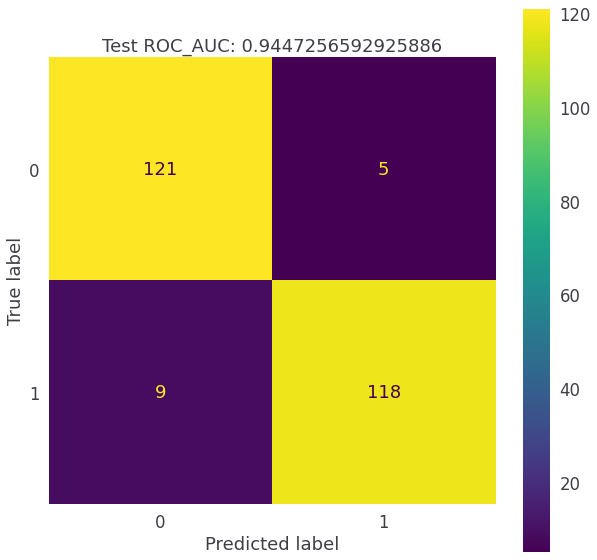

In [157]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(model, X_test, y_test, ax=ax)

ax.grid(False)
ax.set_title(f'Test ROC_AUC: {roc_auc_score(y_test, preds)}')

## 4. Anomalies detection

In [199]:
from sklearn.neighbors import LocalOutlierFactor

X, y = cl_data.drop('PotentialFraud', axis=1).copy(), cl_data.PotentialFraud.copy()

lof = LocalOutlierFactor(n_neighbors=50).fit_predict(X)
lof = ((-lof + 1) / 2).astype(int) # because anomaly detection output is -1, 1 instead of 1, 0

In [200]:
from sklearn.metrics import recall_score, precision_score

print(f'Unsupervised ROC_AUC: {roc_auc_score(y, lof)}')
print(f'Unsupervised recall: {recall_score(y, lof)}')
print(f'Unsupervised precision: {precision_score(y, lof)}')

Unsupervised ROC_AUC: 0.5058414039680441
Unsupervised recall: 0.04940711462450593
Unsupervised precision: 0.11904761904761904


In [211]:
from sklearn.ensemble import IsolationForest

isofor = IsolationForest(n_estimators=20).fit_predict(X)
isofor = ((-isofor + 1) / 2).astype(int) # because lof output is -1, 1 instead of 1, 0

In [212]:
from sklearn.metrics import recall_score, precision_score

print(f'Unsupervised ROC_AUC: {roc_auc_score(y, isofor)}')
print(f'Unsupervised recall: {recall_score(y, isofor)}')
print(f'Unsupervised precision: {precision_score(y, isofor)}')

Unsupervised ROC_AUC: 0.7263841245994236
Unsupervised recall: 0.5296442687747036
Unsupervised precision: 0.41550387596899224
